<div style="
    background-color: #E3F2FD; 
    padding: 20px; 
    text-align: center;"
    >
    <h1 style="color: darkblue; font-family: Poppins, sans-serif; margin-bottom: 5px; font-weight: bold;">
        Trực quan hóa dữ liệu về diễn biến dịch Covid-19
    </h1>
    <h3 style="color:darkblue; font-family: Poppins, sans-serif; margin-top: 0;">
        Nhóm 9
    </h3>

<hr style="border: 2x solid darkblue;">
</div>


### Chuẩn bị dữ liệu

**Import các thư viện cần thiết**

In [91]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

RAW_DATA_PATH = r"../data/raw"
PROCESSED_DATA_PATH = r"../data/processed/daily_data"

**Dữ liệu diễn biến dịch Covid 19 theo ngày**

In [92]:
daily_files = [
    'daily_confirmed_cases.csv',
    'daily_deaths_cases.csv',
    'daily_recovered_cases.csv'
]

In [93]:
daily_data = {}
for file in daily_files:
    df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, file))
    key = file.replace("daily_", "").replace("_cases.csv", "")
    daily_data[key] = df
    print(f"{key}: {df.shape}")

confirmed: (193, 497)
deaths: (193, 497)
recovered: (193, 497)


Dữ liệu có 193 hàng (tương ứng số lượng quốc gia, khu vực khảo sát) và 497 cột (tương ứng các đặc trưng tên quốc gia, kinh độ, vĩ độ, số ca theo ngày)

In [94]:
confirmed_df = daily_data.get("confirmed")
deaths_df = daily_data.get("deaths")
recovered_df = daily_data.get("recovered")

In [95]:
def reshape_daily_wide_file(df, value_name):
    df_long = df.melt(
        id_vars=['Country/Region', 'Lat', 'Long'], 
        var_name='ObservationDate', 
        value_name=value_name  
    )
    df_long['ObservationDate'] = pd.to_datetime(df_long['ObservationDate'], format="%m/%d/%y", errors='coerce')
    return df_long


confirmed_long = reshape_daily_wide_file(confirmed_df, "Confirmed") 
deaths_long = reshape_daily_wide_file(deaths_df, "Deaths") 
recovered_long = reshape_daily_wide_file(recovered_df, "Recovered") 

covid_data = confirmed_long.merge(
    deaths_long, 
    on=['Country/Region', 'Lat', 'Long', 'ObservationDate'], 
    how='outer'
)

covid_data = covid_data.merge(
    recovered_long, 
    on=['Country/Region', 'Lat', 'Long', 'ObservationDate'], 
    how='outer'
)


Kiểm tra khoảng giá trị ngày tháng của dữ liệu 

In [96]:

covid_data['ObservationDate'] = pd.to_datetime(covid_data['ObservationDate'], errors='coerce')

start_date = covid_data['ObservationDate'].min()
end_date = covid_data['ObservationDate'].max()

print(f"Date Range: {start_date.date()} to {end_date.date()}")


Date Range: 2020-01-22 to 2021-05-29


## Phân tích dữ liệu để tìm hiểu xu hướng của dịch bệnh

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_trend_analysis(df, country=None):
    """
    Hàm vẽ biểu đồ xu hướng số ca nhiễm, tử vong và hồi phục theo thời gian.

    Parameters:
    ---
    df : pandas.DataFrame chứa dữ liệu Covid-19
    country : str, optional
        Tên quốc gia cần phân tích (ví dụ: "Vietnam", "United States").
        Nếu không truyền vào, hàm hiển thị dữ liệu toàn cầu.
    """
    sns.set(style="whitegrid")

    # Đảm bảo cột ObservationDate là datetime
    df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])

    # Lọc theo quốc gia nếu được cung cấp
    if country:
        df = df[df['Country/Region'] == country]

    # Gom nhóm theo ngày
    daily = df.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

    # Tính trung bình trong đoạn cửa sổ trượt 7 ngày
    daily['Confirmed_MA'] = daily['Confirmed'].rolling(window=7).mean()
    daily['Deaths_MA'] = daily['Deaths'].rolling(window=7).mean()
    daily['Recovered_MA'] = daily['Recovered'].rolling(window=7).mean()

    plt.figure(figsize=(14, 7))

    # Confirmed trend
    plt.subplot(3, 1, 1)
    sns.lineplot(data=daily, x='ObservationDate', y='Confirmed_MA', color='blue')
    plt.title(f'Xu hướng số ca nhiễm được xác nhận{" tại " + country if country else ""}')
    plt.ylabel('Số ca nhiễm (7-day MA)')
    plt.xlabel('Ngày')

    # Deaths trend
    plt.subplot(3, 1, 2)
    sns.lineplot(data=daily, x='ObservationDate', y='Deaths_MA', color='red')
    plt.title(f'Xu hướng số ca tử vong{" tại " + country if country else ""}')
    plt.ylabel('Số ca tử vong (7-day MA)')
    plt.xlabel('Ngày')

    # Recovered trend
    plt.subplot(3, 1, 3)
    sns.lineplot(data=daily, x='ObservationDate', y='Recovered_MA', color='green')
    plt.title(f'Xu hướng số ca hồi phục{" tại " + country if country else ""}')
    plt.ylabel('Số ca hồi phục (7-day MA)')
    plt.xlabel('Ngày')

    plt.tight_layout()
    plt.show()


In [98]:
def plot_comparison_trend(df, countries):
    """
    Hàm vẽ biểu đồ so sánh xu hướng số ca nhiễm giữa các quốc gia.

    Parameters:
    ---
    df : pandas.DataFrame chứa dữ liệu Covid-19 với các cột
    countries : list
        List các quốc gia cần so sánh (ví dụ: ["Vietnam", "United States", "India"]).
    """
    sns.set(style="whitegrid")
    df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])

    plt.figure(figsize=(14, 8))

    for country in countries:
        country_df = df[df['Country/Region'] == country]
        daily = country_df.groupby('ObservationDate')['Confirmed'].sum().rolling(window=7).mean().reset_index()
        sns.lineplot(data=daily, x='ObservationDate', y='Confirmed', label=country)

    plt.title("So sánh xu hướng số ca nhiễm giữa các quốc gia")
    plt.xlabel("Ngày")
    plt.ylabel("Số ca nhiễm (7-day MA)")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Xu hướng dịch COVID 19 toàn cầu theo tuần

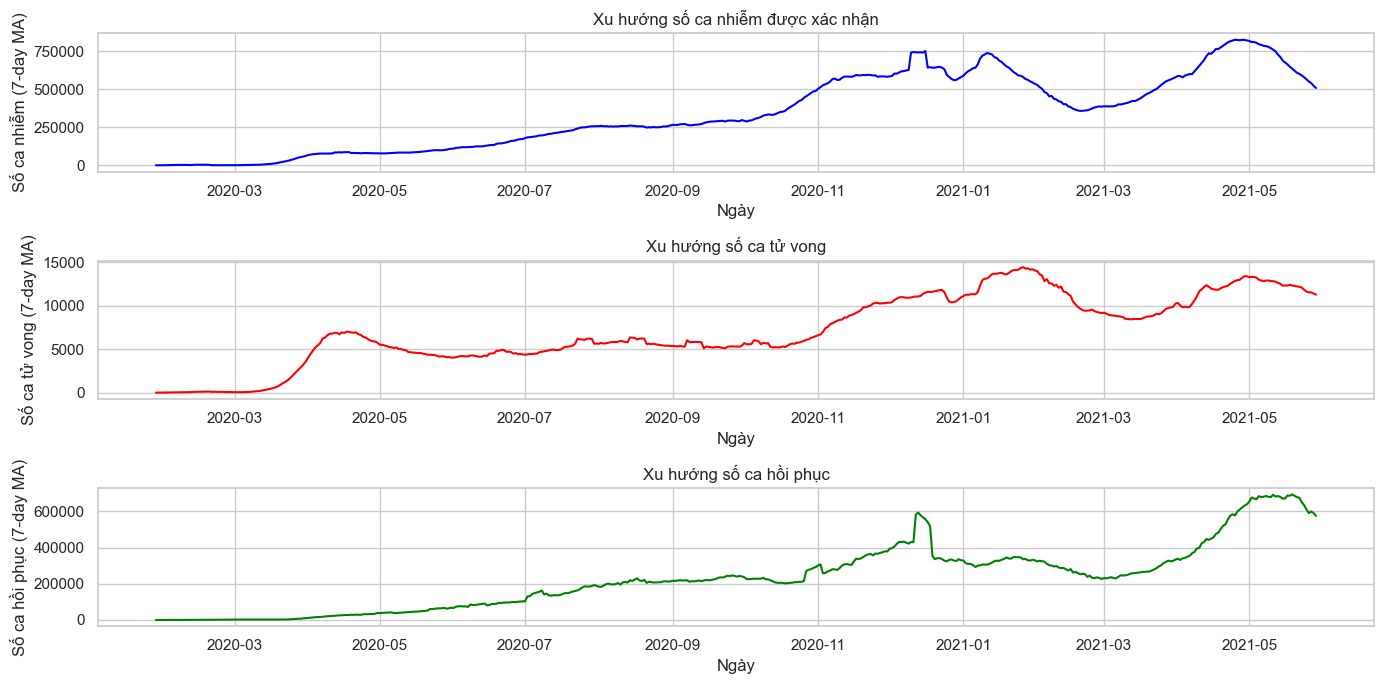

In [99]:
plot_trend_analysis(covid_data)

**Nhận xét:**  

- Số ca nhiễm và tử vong đều có xu hướng tăng qua từng đợt bùng phát dịch, và đều đạt đỉnh lớn vào cuối năm 2020 đầu năm 2021, phản ánh được giai đoạn dịch bùng phát mạnh.

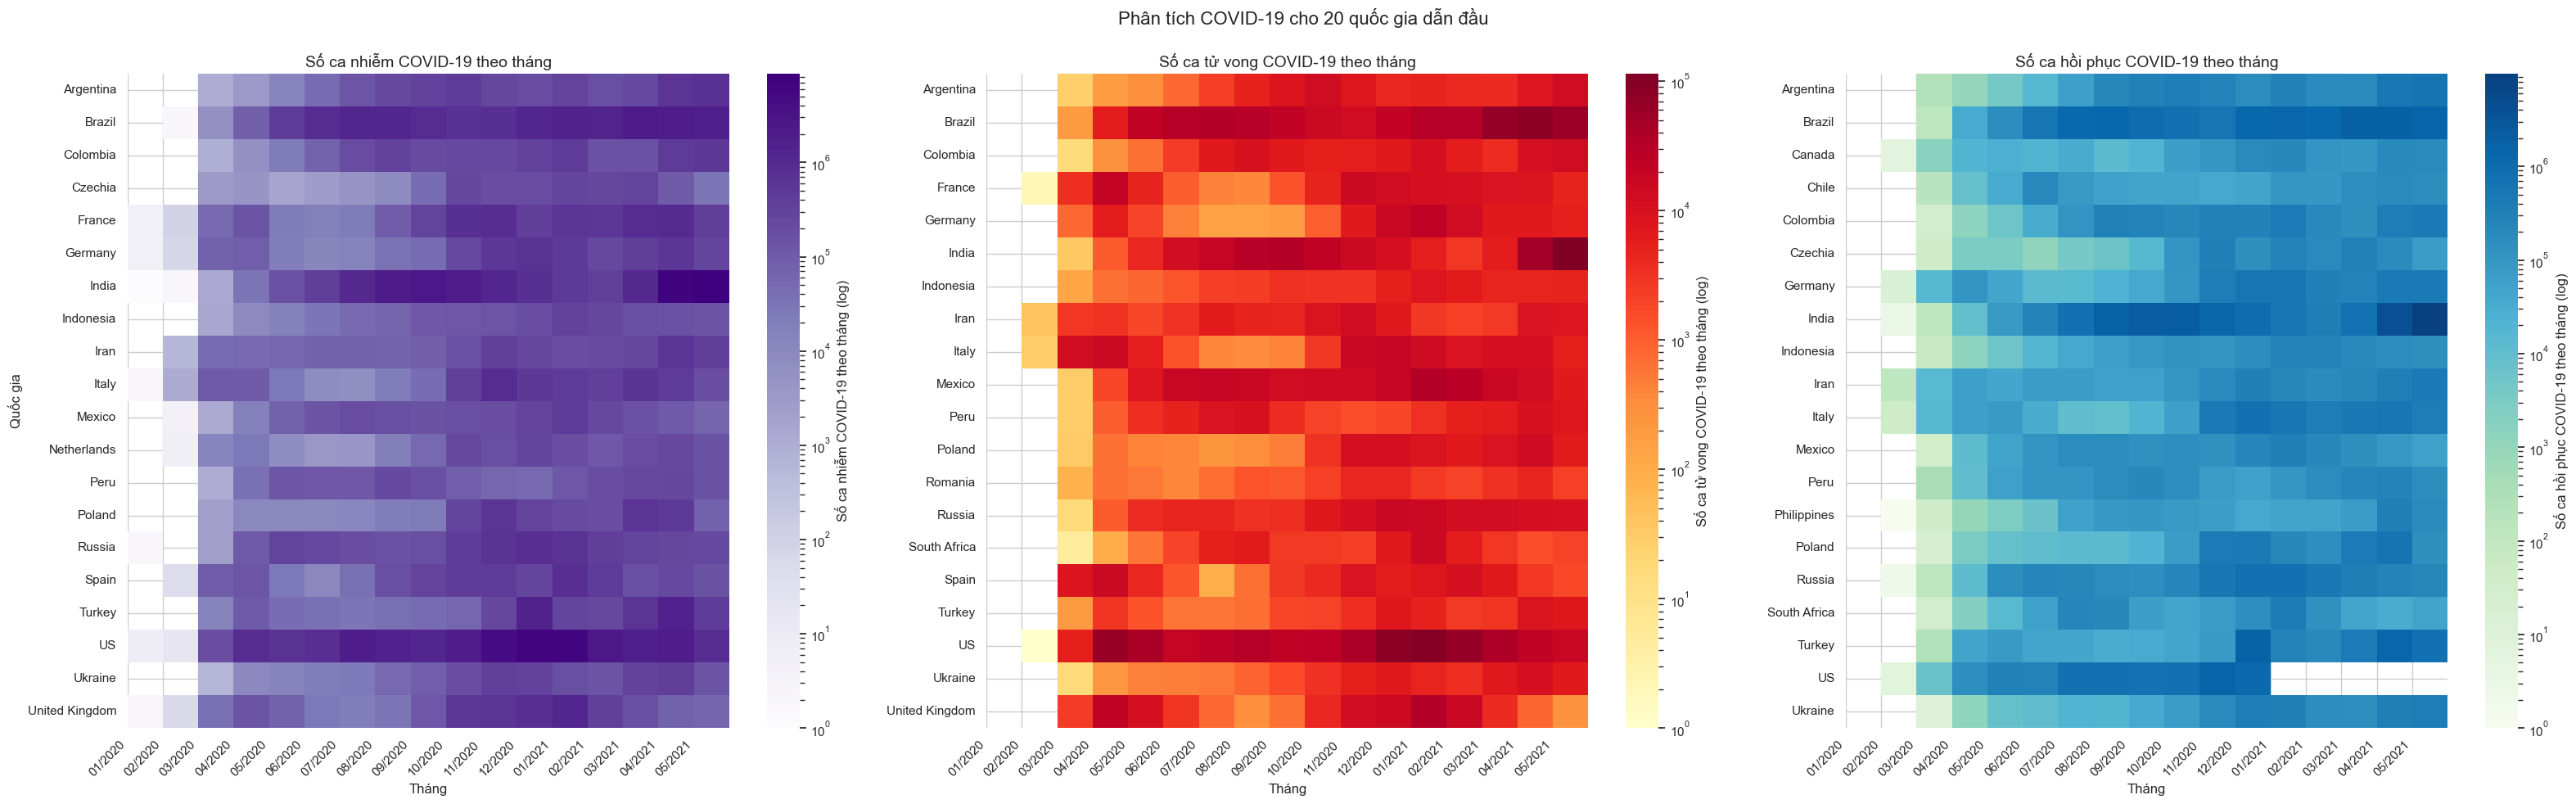

In [100]:
def prepare_heatmap_data(df, column_name):
    df['Total'] = df.iloc[:, 3:].sum(axis=1)
    top_countries = df.nlargest(20, 'Total')['Country/Region'].tolist()
    
    df_top = df[df['Country/Region'].isin(top_countries)]
    
    df_melt = df_top.melt(id_vars=['Country/Region'], 
                          value_vars=df.columns[3:-1], 
                          var_name='Date', 
                          value_name=column_name)
    
    df_melt['Date'] = pd.to_datetime(df_melt['Date'], format='%m/%d/%y')
    df_melt['Month'] = df_melt['Date'].dt.to_period('M').dt.to_timestamp()
    df_monthly = df_melt.groupby(['Country/Region', 'Month'])[column_name].sum().reset_index()
    
    heatmap_data = df_monthly.pivot(index='Country/Region', 
                                    columns='Month', 
                                    values=column_name)
    
    return heatmap_data, df_monthly

def create_heatmap(ax, data, title, color_map, show_ylabel=True):
    sns.heatmap(data, 
                ax=ax,
                cmap=color_map,
                norm=LogNorm(),
                cbar_kws={'label': title + ' (log)'})
    
    # Format x-axis labels
    month_labels = [date.strftime('%m/%Y') for date in data.columns]
    ax.set_xticks(range(len(month_labels)))
    ax.set_xticklabels(month_labels, rotation=45, ha='right')
    
    # Set titles and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Tháng', fontsize=12)
    
    if show_ylabel:
        ax.set_ylabel('Quốc gia', fontsize=12)
    else:
        ax.set_ylabel('', fontsize=0)
    
    return ax

fig, axes = plt.subplots(1, 3, figsize=(32, 10))

confirmed_data, confirmed_monthly = prepare_heatmap_data(confirmed_df, 'Cases')
deaths_data, deaths_monthly = prepare_heatmap_data(deaths_df, 'Cases')
recovered_data, recovered_monthly = prepare_heatmap_data(recovered_df, 'Cases')

create_heatmap(axes[0], confirmed_data, 'Số ca nhiễm COVID-19 theo tháng', 'Purples', True)
create_heatmap(axes[1], deaths_data, 'Số ca tử vong COVID-19 theo tháng', 'YlOrRd', False)
create_heatmap(axes[2], recovered_data, 'Số ca hồi phục COVID-19 theo tháng', 'GnBu', False)

plt.suptitle('Phân tích COVID-19 cho 20 quốc gia dẫn đầu', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.90)  

plt.show()

**Nhận xét:**

3 biểu đồ heatmap này cho thấy sự biến động của đại dịch COVID-19 tại 20 quốc gia dẫn đầu về số ca nhiễm trong khoảng thời gian từ đầu năm 2020 đến đầu năm 2021. Nhìn chung, cả 3 biểu đồ đều có màu chuyển đậm dần, thể hiện một xu hướng tăng dần theo thời gian. Biểu đồ thể hiện rõ làn sóng lây nhiễm, tử vong và hồi phục diễn ra không đồng đều giữa các quốc gia, với một số nước chịu tác động nặng nề hơn ở các thời điểm khác nhau trong đại dịch.

### Khảo sát diễn biến tại một số quốc gia cụ thể tại các khu vực trên thế giới 

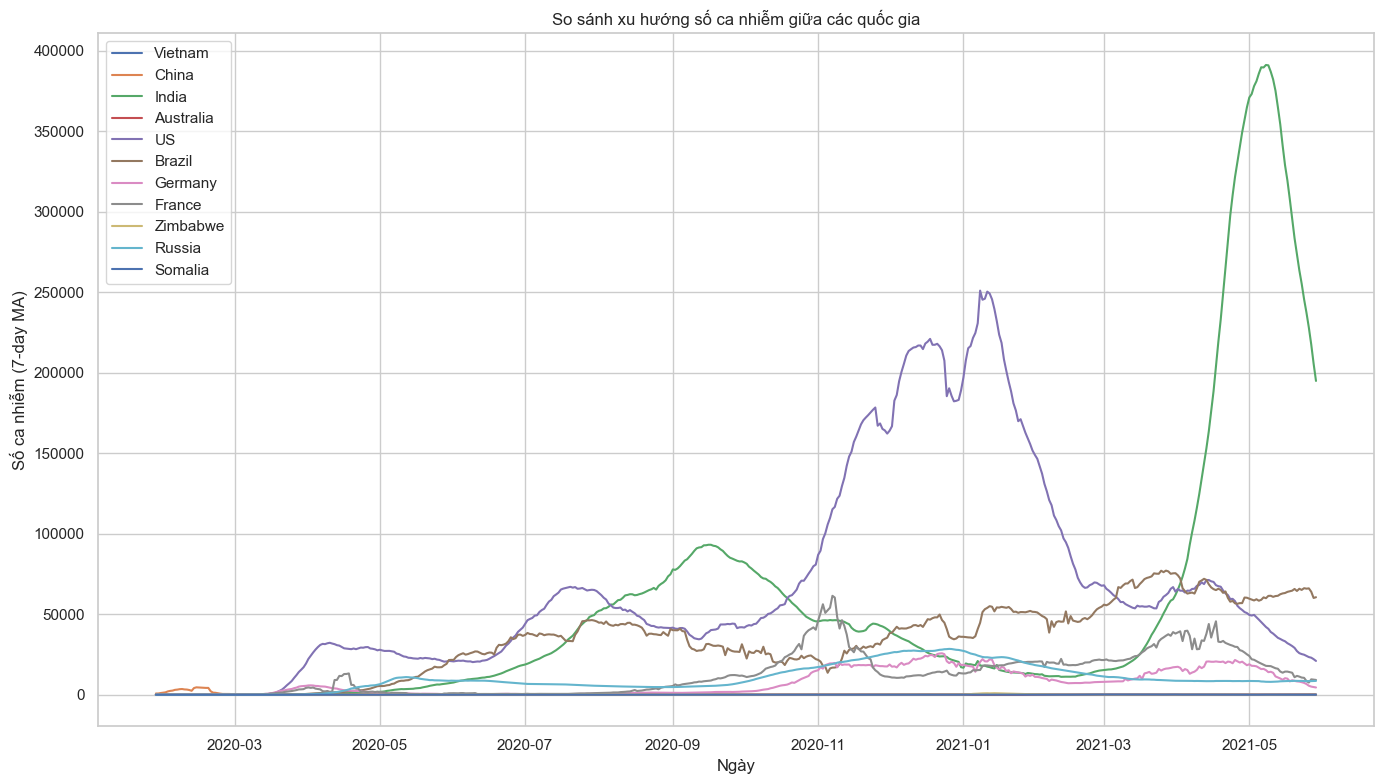

In [101]:
plot_comparison_trend(covid_data, countries=["Vietnam", "China", "India", "Australia","US",  "Brazil", "Germany", "France", "Zimbabwe", "Russia", "Somalia"])


**Nhận xét**
- Biểu đồ thể hiện xu hướng số ca nhiễm COVID-19 tại một số quốc gia đại diện cho các châu lục trên thế giới. Mỹ đại diện cho Bắc Mỹ, Brazil cho Nam Mỹ, Ấn Độ và Vietnam cho châu Á, Nga và Pháp cho châu Âu, Zimbabwe và Somalia cho châu Phi, còn Australia đại diện cho châu Đại Dương.
- Mỹ và Ấn Độ có số ca nhiễm cao nhất, với Ấn Độ đạt đỉnh khoảng 400.000 ca/ngày vào giữa năm 2021.
- Brazil và Nga có số ca nhiễm cao nhưng không tăng đột biến như Mỹ hay Ấn Độ.
- Việt Nam, Somalia và Zimbabwe có số ca nhiễm thấp hơn đáng kể so với các quốc gia khác.

**Suy đoán:**
- Các quốc gia châu Phi như Somalia, Zimbabwe có số ca nhiễm thấp hơn, có thể do điều kiện xét nghiệm hạn chế hoặc khác biệt về nhân khẩu học, khí hậu và mức độ di chuyển quốc tế.

### Khảo sát diễn biến dịch tại Trung Quốc

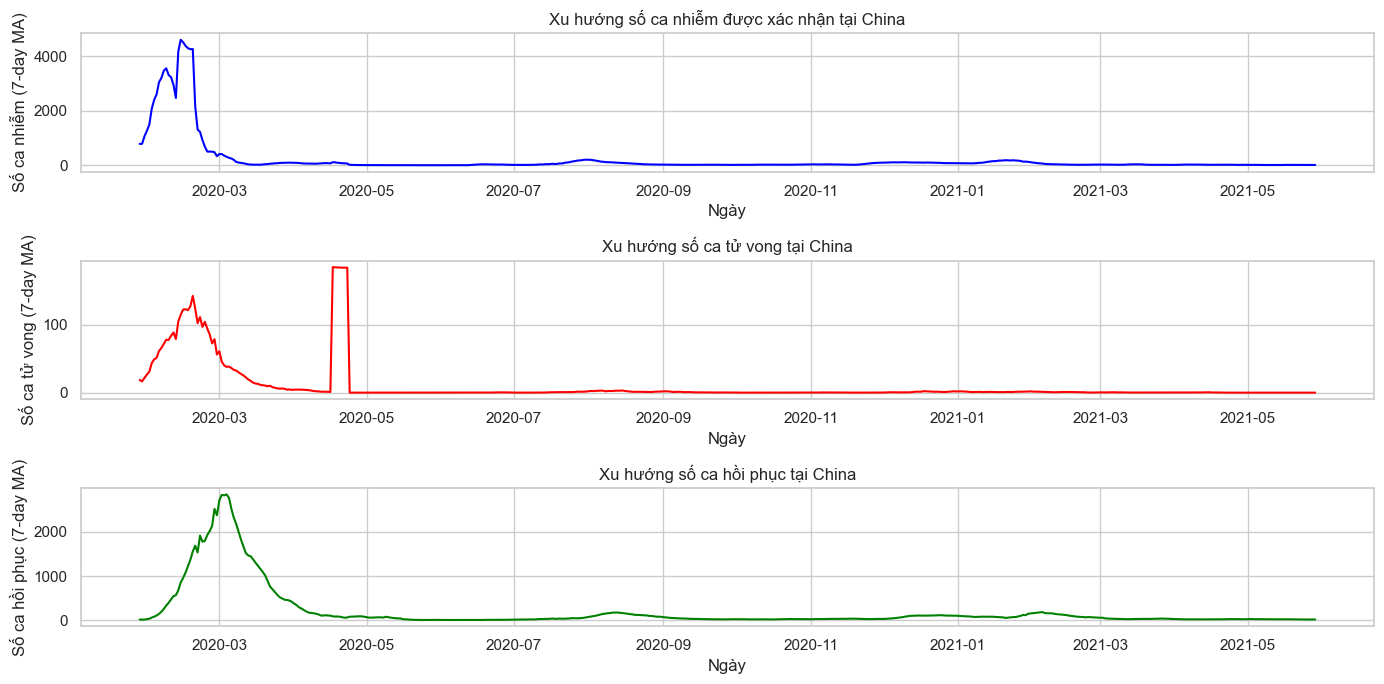

In [102]:
plot_trend_analysis(covid_data, country="China")

**Nhận xét:**
- Đầu năm 2020, Trung Quốc trải qua đợt bùng phát dịch COVID-19 lớn, thể hiện qua sự tăng vọt của số ca nhiễm, tử vong và hồi phục.
- Sau đợt bùng phát trên, cả 3 chỉ số đều giảm mạnh và duy trì ở mức thấp, cho thấy Trung Quốc đã kiểm soát dịch bệnh thành công trong giai đoạn này

### Thống kê và so sánh mức độ gia tăng ca nhiễm COVID-19 hàng ngày và hàng tuần trên toàn thế giới 

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử bạn đã có: covid_data (dữ liệu gốc)
df_full_grouped = covid_data.copy()

# Đảm bảo cột ngày đúng kiểu
df_full_grouped['ObservationDate'] = pd.to_datetime(df_full_grouped['ObservationDate'])

# Gom nhóm theo ngày (toàn cầu hoặc quốc gia tùy chọn)
df_full_grouped = df_full_grouped.groupby('ObservationDate')[['Confirmed', 'Deaths']].sum().reset_index()

# Tính tăng trưởng hằng ngày (daily growth rate %)
df_full_grouped['Tốc độ gia tăng của số ca nhiễm hắng ngày'] = df_full_grouped['Confirmed'].pct_change().fillna(0) * 100
df_full_grouped['Tốc độ gia tăng của số ca tử vong hằng ngày'] = df_full_grouped['Deaths'].pct_change().fillna(0) * 100

# Tăng trưởng hằng tuần (so với 7 ngày trước)
df_full_grouped['Tốc độ gia tăng của số ca nhiễm hằng tuần'] = df_full_grouped['Confirmed'].pct_change(periods=7).fillna(0) * 100
df_full_grouped['Tốc độ gia tăng của số ca tử vong hằng tuần'] = df_full_grouped['Deaths'].pct_change(periods=7).fillna(0) * 100

# Xem dữ liệu
df_full_grouped.head(50)[['ObservationDate', 'Confirmed', 'Deaths',
                          'Tốc độ gia tăng của số ca nhiễm hắng ngày', 'Tốc độ gia tăng của số ca tử vong hằng ngày',
                          'Tốc độ gia tăng của số ca nhiễm hằng tuần', 'Tốc độ gia tăng của số ca tử vong hằng tuần']]


,ObservationDate,Confirmed,Deaths,Tốc độ gia tăng của số ca nhiễm hắng ngày,Tốc độ gia tăng của số ca tử vong hằng ngày,Tốc độ gia tăng của số ca nhiễm hằng tuần,Tốc độ gia tăng của số ca tử vong hằng tuần
0,2020-01-22,557.0,17.0,0.000000,0.000000,0.000000,0.000000
1,2020-01-23,98.0,1.0,-82.405745,-94.117647,0.000000,0.000000
2,2020-01-24,286.0,8.0,191.836735,700.000000,0.000000,0.000000
3,2020-01-25,492.0,16.0,72.027972,100.000000,0.000000,0.000000
4,2020-01-26,685.0,14.0,39.227642,-12.500000,0.000000,0.000000
5,2020-01-27,809.0,26.0,18.102190,85.714286,0.000000,0.000000
6,2020-01-28,2651.0,49.0,227.688504,88.461538,0.000000,0.000000
7,2020-01-29,589.0,2.0,-77.781969,-95.918367,5.745063,-88.235294
8,2020-01-30,2068.0,38.0,251.103565,1800.000000,2010.204082,3700.000000
9,2020-01-31,1692.0,42.0,-18.181818,10.526316,491.608392,425.000000


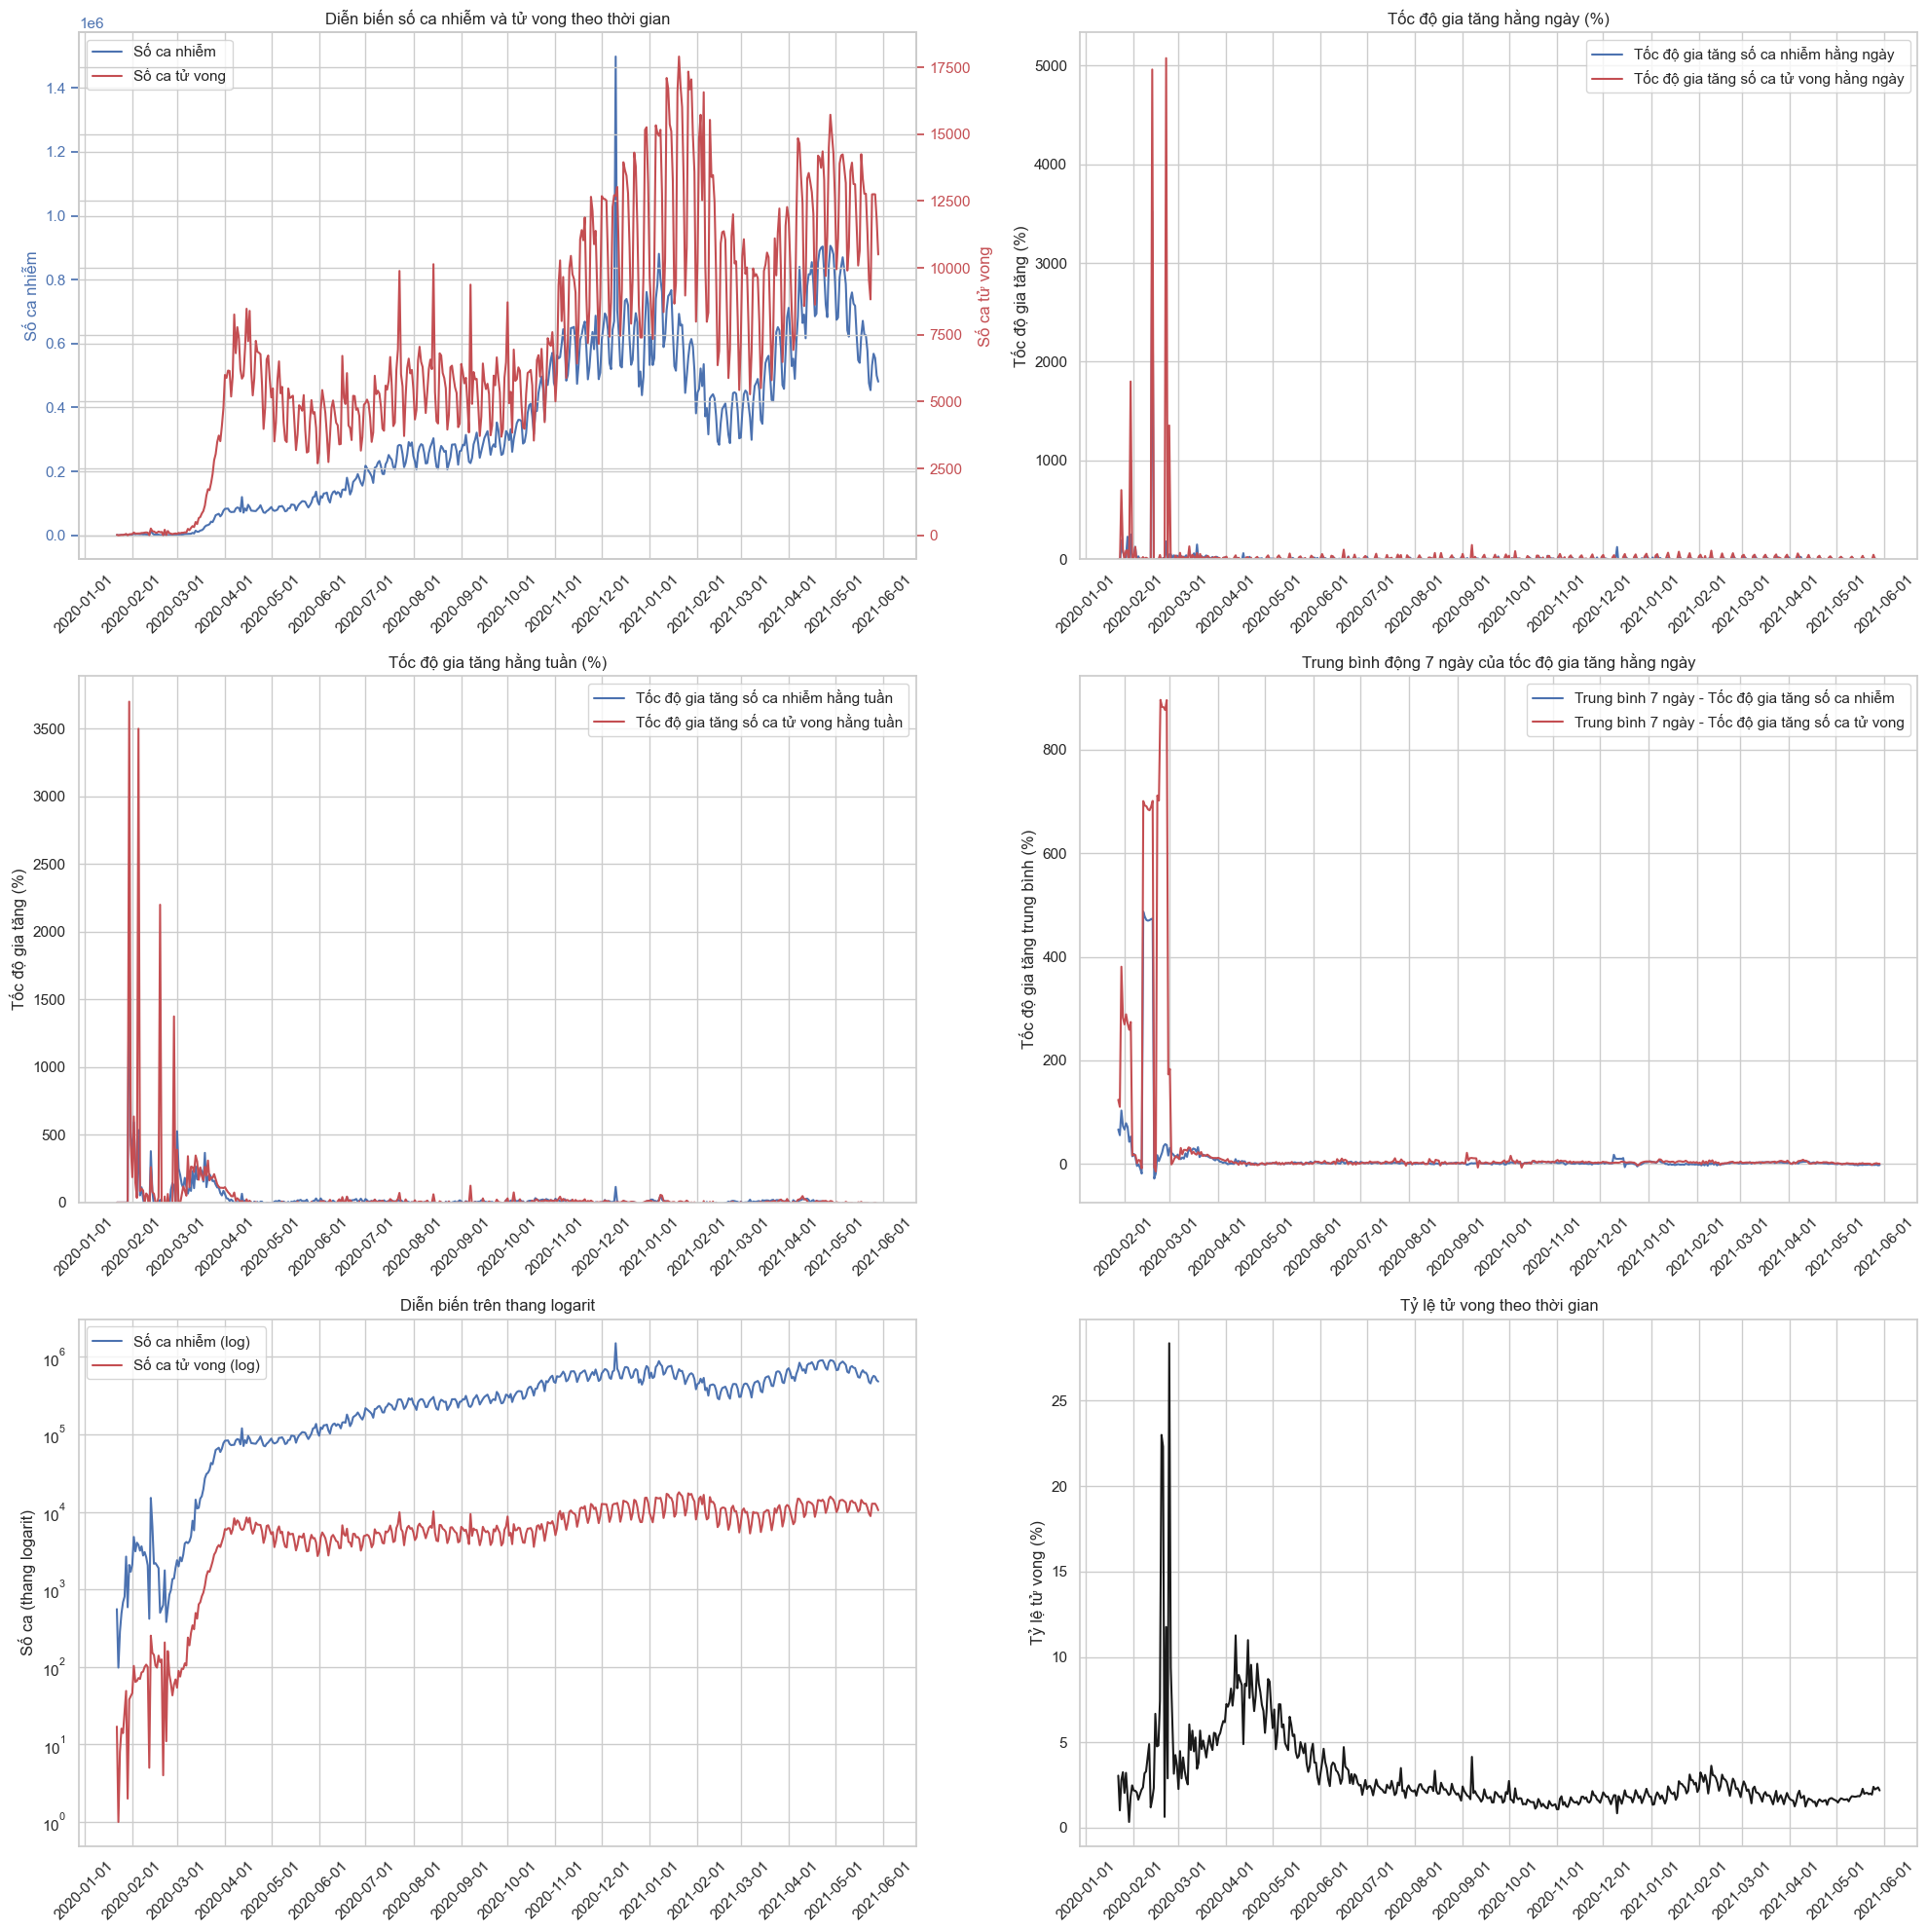

In [104]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(20, 20))

# 1. Diễn biến số ca nhiễm và tử vong theo thời gian
ax1 = plt.subplot(3, 2, 1)
ax1.plot(df_full_grouped['ObservationDate'], df_full_grouped['Confirmed'], 'b-', label='Số ca nhiễm')
ax1.set_ylabel('Số ca nhiễm', color='b')
ax1.tick_params('y', colors='b')
ax1.set_title('Diễn biến số ca nhiễm và tử vong theo thời gian')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Twin axis for deaths
ax1_twin = ax1.twinx()
ax1_twin.plot(df_full_grouped['ObservationDate'], df_full_grouped['Deaths'], 'r-', label='Số ca tử vong')
ax1_twin.set_ylabel('Số ca tử vong', color='r')
ax1_twin.tick_params('y', colors='r')

# Create combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 2. TTốc độ gia tăng số ca tử vong hằng ngày
ax2 = plt.subplot(3, 2, 2)
ax2.plot(df_full_grouped['ObservationDate'], df_full_grouped['Tốc độ gia tăng của số ca nhiễm hắng ngày'], 'b-', 
         label='Tốc độ gia tăng số ca nhiễm hằng ngày')
ax2.plot(df_full_grouped['ObservationDate'], df_full_grouped['Tốc độ gia tăng của số ca tử vong hằng ngày'], 'r-', 
         label='Tốc độ gia tăng số ca tử vong hằng ngày')
ax2.set_ylabel('Tốc độ gia tăng (%)')
ax2.set_title('Tốc độ gia tăng hằng ngày (%)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.legend()
plt.xticks(rotation=45)
ax2.set_ylim(bottom=0)  # Start from 0

# 3. Tốc độ gia tăng số ca tử vong hằng tuần
ax3 = plt.subplot(3, 2, 3)
ax3.plot(df_full_grouped['ObservationDate'], df_full_grouped['Tốc độ gia tăng của số ca nhiễm hằng tuần'], 'b-', 
         label='Tốc độ gia tăng số ca nhiễm hằng tuần')
ax3.plot(df_full_grouped['ObservationDate'], df_full_grouped['Tốc độ gia tăng của số ca tử vong hằng tuần'], 'r-', 
         label='Tốc độ gia tăng số ca tử vong hằng tuần')
ax3.set_ylabel('Tốc độ gia tăng (%)')
ax3.set_title('Tốc độ gia tăng hằng tuần (%)')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.MonthLocator())
ax3.legend()
plt.xticks(rotation=45)
ax3.set_ylim(bottom=0)  # Start from 0

# 4. Trung bình trượt 7 ngày của tốc độ gia tăng hằng ngày
ax4 = plt.subplot(3, 2, 4)
ax4.plot(df_full_grouped['ObservationDate'], 
         df_full_grouped['Tốc độ gia tăng của số ca nhiễm hắng ngày'].rolling(window=7).mean(), 'b-', 
         label='Trung bình 7 ngày - Tốc độ gia tăng số ca nhiễm')
ax4.plot(df_full_grouped['ObservationDate'], 
         df_full_grouped['Tốc độ gia tăng của số ca tử vong hằng ngày'].rolling(window=7).mean(), 'r-', 
         label='Trung bình 7 ngày - Tốc độ gia tăng số ca tử vong')
ax4.set_ylabel('Tốc độ gia tăng trung bình (%)')
ax4.set_title('Trung bình động 7 ngày của tốc độ gia tăng hằng ngày')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax4.xaxis.set_major_locator(mdates.MonthLocator())
ax4.legend()
plt.xticks(rotation=45)

# 5. Diễn biến trên thang logarit
ax5 = plt.subplot(3, 2, 5)
ax5.semilogy(df_full_grouped['ObservationDate'], df_full_grouped['Confirmed'], 'b-', label='Số ca nhiễm (log)')
ax5.semilogy(df_full_grouped['ObservationDate'], df_full_grouped['Deaths'], 'r-', label='Số ca tử vong (log)')
ax5.set_ylabel('Số ca (thang logarit)')
ax5.set_title('Diễn biến trên thang logarit')
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax5.xaxis.set_major_locator(mdates.MonthLocator())
ax5.legend()
plt.xticks(rotation=45)

# 6. Tỷ lệ tử vong theo thời gian
ax6 = plt.subplot(3, 2, 6)
mortality_rate = (df_full_grouped['Deaths'] / df_full_grouped['Confirmed']) * 100
ax6.plot(df_full_grouped['ObservationDate'], mortality_rate, 'k-')
ax6.set_ylabel('Tỷ lệ tử vong (%)')
ax6.set_title('Tỷ lệ tử vong theo thời gian')
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax6.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Top 10 quốc gia có nhiều ca nhiễm, tử vong, hồi phục

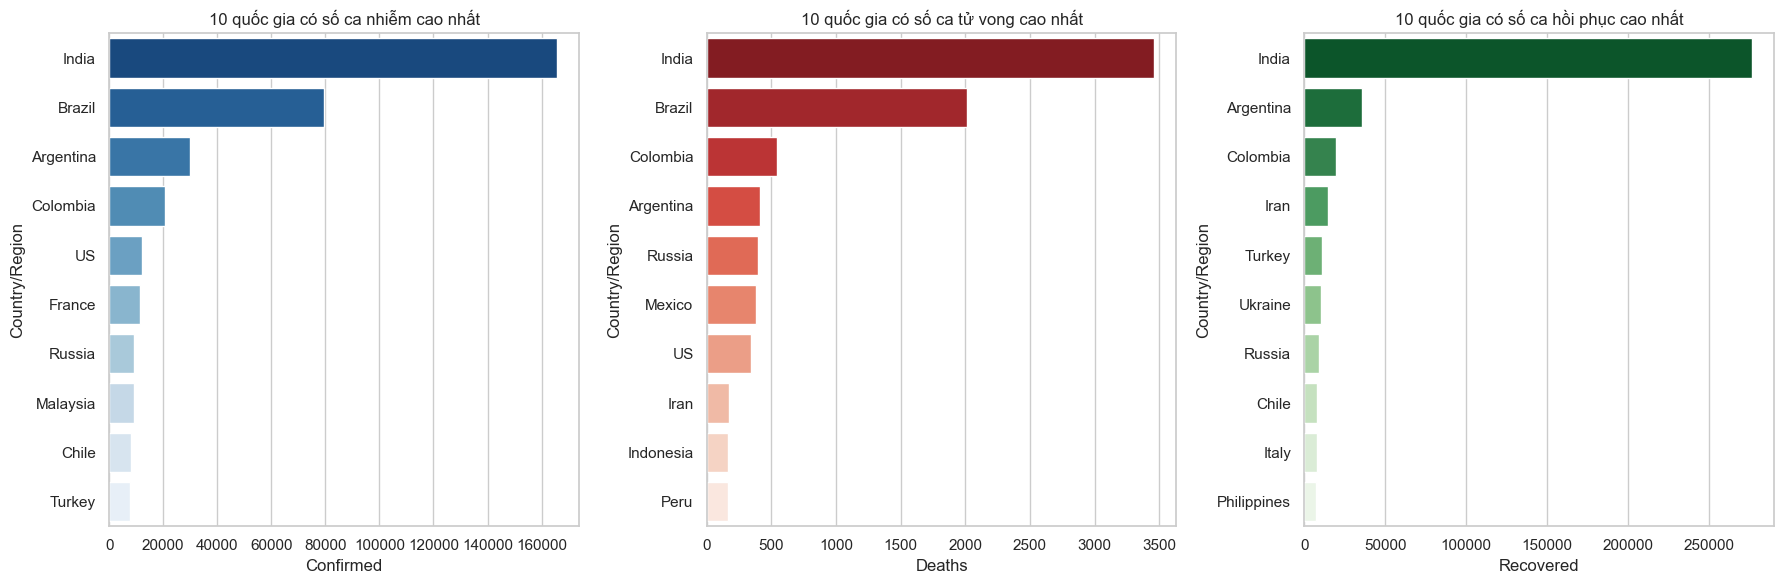

In [105]:
# Lấy dữ liệu mới nhất theo từng quốc gia
df_country_wise_latest = covid_data.copy()
latest_date = df_country_wise_latest['ObservationDate'].max()

# Lọc data mới nhất
df_country_wise_latest = df_country_wise_latest[df_country_wise_latest['ObservationDate'] == latest_date]
df_country_wise_latest = df_country_wise_latest.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Top 10 quốc gia theo từng chỉ số
top_countries_cases = df_country_wise_latest.nlargest(10, 'Confirmed')[['Country/Region', 'Confirmed']]
top_countries_deaths = df_country_wise_latest.nlargest(10, 'Deaths')[['Country/Region', 'Deaths']]
top_countries_recovered = df_country_wise_latest.nlargest(10, 'Recovered')[['Country/Region', 'Recovered']]

# Vẽ biểu đồ bar
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Confirmed cases
sns.barplot(x='Confirmed', y='Country/Region',
            data=top_countries_cases, ax=axes[0],
            palette='Blues_r', hue='Country/Region', legend=False)
axes[0].set_title('10 quốc gia có số ca nhiễm cao nhất')
# Deaths
sns.barplot(x='Deaths', y='Country/Region',
            data=top_countries_deaths, ax=axes[1],
            palette='Reds_r', hue='Country/Region', legend=False)
axes[1].set_title("10 quốc gia có số ca tử vong cao nhất")

# Recovered
sns.barplot(x='Recovered', y='Country/Region',
            data=top_countries_recovered, ax=axes[2],
            palette='Greens_r', hue='Country/Region', legend=False)
axes[2].set_title('10 quốc gia có số ca hồi phục cao nhất')

plt.tight_layout()
plt.show()


### Tính tỷ lệ tử vong và hồi phục

In [106]:
df_country_wise_latest["Tỉ lệ tử vong (%)"] = (df_country_wise_latest['Deaths'] / df_country_wise_latest['Confirmed']) * 100
df_country_wise_latest["Tỉ lệ hồi phục (%)"] = (df_country_wise_latest['Recovered'] / df_country_wise_latest['Confirmed']) * 100

# Hiển thị kết quả
df_country_wise_latest[['Country/Region', 'Confirmed', 'Deaths', 'Recovered',
                        'Tỉ lệ tử vong (%)', 'Tỉ lệ hồi phục (%)']].head(10)


,Country/Region,Confirmed,Deaths,Recovered,Tỉ lệ tử vong (%),Tỉ lệ hồi phục (%)
0,Afghanistan,981.0,18.0,162.0,1.834862,16.513761
1,Albania,12.0,1.0,118.0,8.333333,983.333333
2,Algeria,258.0,5.0,187.0,1.937984,72.480620
3,Andorra,0.0,0.0,0.0,NaN,NaN
4,Angola,236.0,8.0,69.0,3.389831,29.237288
5,Antigua and Barbuda,0.0,0.0,0.0,NaN,NaN
6,Argentina,29841.0,415.0,35624.0,1.390704,119.379377
7,Armenia,42.0,5.0,186.0,11.904762,442.857143
8,Australia,13.0,0.0,4.0,0.000000,30.769231
9,Austria,498.0,4.0,857.0,0.803213,172.088353


### Phân tích và so sánh xu hướng theo tháng và tuần

In [107]:
df_full_grouped = covid_data.copy()
df_full_grouped['ObservationDate'] = pd.to_datetime(df_full_grouped['ObservationDate'])

# Gom nhóm toàn cầu theo ngày
df_full_grouped = df_full_grouped.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Thêm cột Month, Week
df_full_grouped['Month'] = df_full_grouped['ObservationDate'].dt.month
df_full_grouped['Week'] = df_full_grouped['ObservationDate'].dt.isocalendar().week

# Gom nhóm theo tháng
monthly_data = df_full_grouped.groupby('Month')[['Confirmed', 'Deaths', 'Recovered']].mean()

# Gom nhóm theo tuần
weekly_data = df_full_grouped.groupby('Week')[['Confirmed', 'Deaths', 'Recovered']].mean()


### Vẽ biểu đồ tháng và tuần

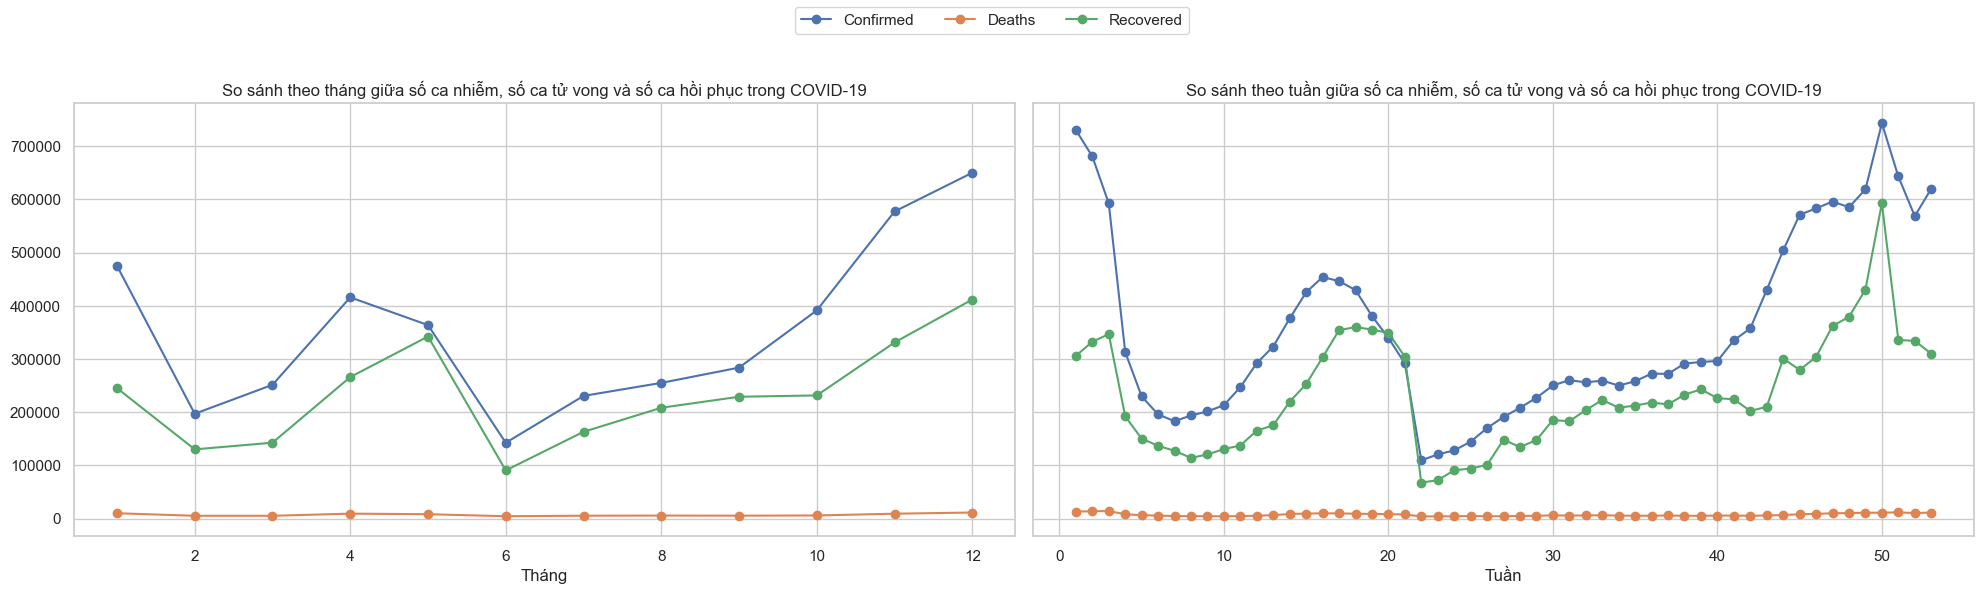

In [108]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)  # Chia sẻ trục y để dễ so sánh

# Biểu đồ theo tháng
monthly_plot = monthly_data.plot(kind='line', marker='o', ax=axes[0], legend=False)
axes[0].set_title('So sánh theo tháng giữa số ca nhiễm, số ca tử vong và số ca hồi phục trong COVID-19')
axes[0].set_xlabel('Tháng')
axes[0].grid(True)

# Biểu đồ theo tuần
weekly_plot = weekly_data.plot(kind='line', marker='o', ax=axes[1], legend=False)
axes[1].set_title('So sánh theo tuần giữa số ca nhiễm, số ca tử vong và số ca hồi phục trong COVID-19')
axes[1].set_xlabel('Tuần')
axes[1].grid(True)

handles, labels = monthly_plot.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels))

# Hiển thị biểu đồ
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Để tránh legend chồng lên biểu đồ
plt.show()


### Tính và vẽ daily new cases/deaths/recoveries cho một quốc gia

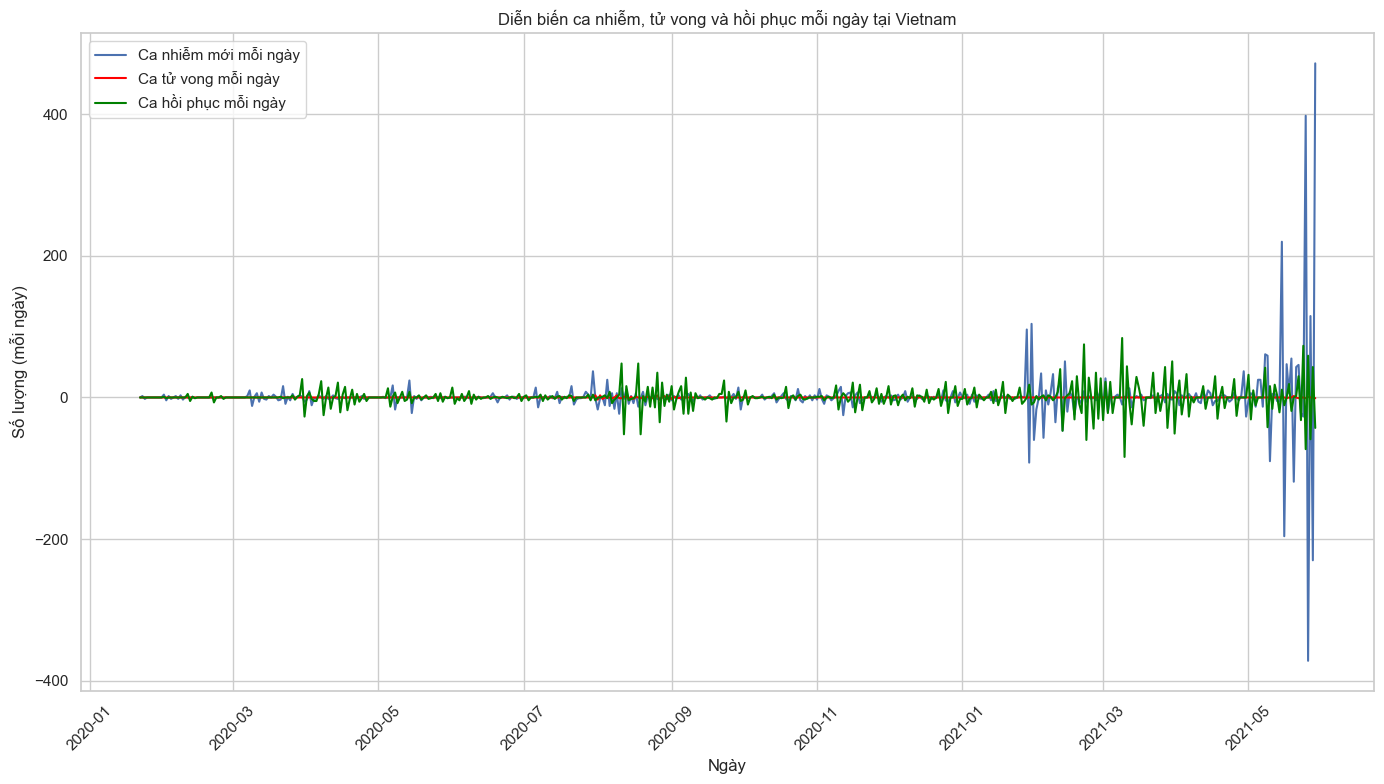

In [109]:
# Bản sao dữ liệu và chuẩn hóa thời gian
df_daily = covid_data.copy()
df_daily['ObservationDate'] = pd.to_datetime(df_daily['ObservationDate'])

# Gom nhóm theo quốc gia và ngày (tránh trùng lặp tỉnh/thành)
df_daily = df_daily.groupby(['Country/Region', 'ObservationDate'])[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
df_daily = df_daily.sort_values(['Country/Region', 'ObservationDate'])

# Tính số ca mới mỗi ngày (dạng diff bình thường)
df_daily['Daily New Cases'] = df_daily.groupby('Country/Region')['Confirmed'].diff().fillna(0)
df_daily['Daily New Deaths'] = df_daily.groupby('Country/Region')['Deaths'].diff().fillna(0)
df_daily['Daily New Recoveries'] = df_daily.groupby('Country/Region')['Recovered'].diff().fillna(0)

# Chọn quốc gia cần vẽ
country_name = 'Vietnam'
sample_country = df_daily[df_daily['Country/Region'] == country_name]

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
sns.lineplot(x='ObservationDate', y='Daily New Cases', data=sample_country, label='Ca nhiễm mới mỗi ngày')
sns.lineplot(x='ObservationDate', y='Daily New Deaths', data=sample_country, label='Ca tử vong mỗi ngày', color='red')
sns.lineplot(x='ObservationDate', y='Daily New Recoveries', data=sample_country, label='Ca hồi phục mỗi ngày', color='green')

plt.title(f'Diễn biến ca nhiễm, tử vong và hồi phục mỗi ngày tại {country_name}')
plt.xlabel('Ngày')
plt.ylabel('Số lượng (mỗi ngày)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Phân tích top 10 quốc gia có số ca nhiễm cao nhất

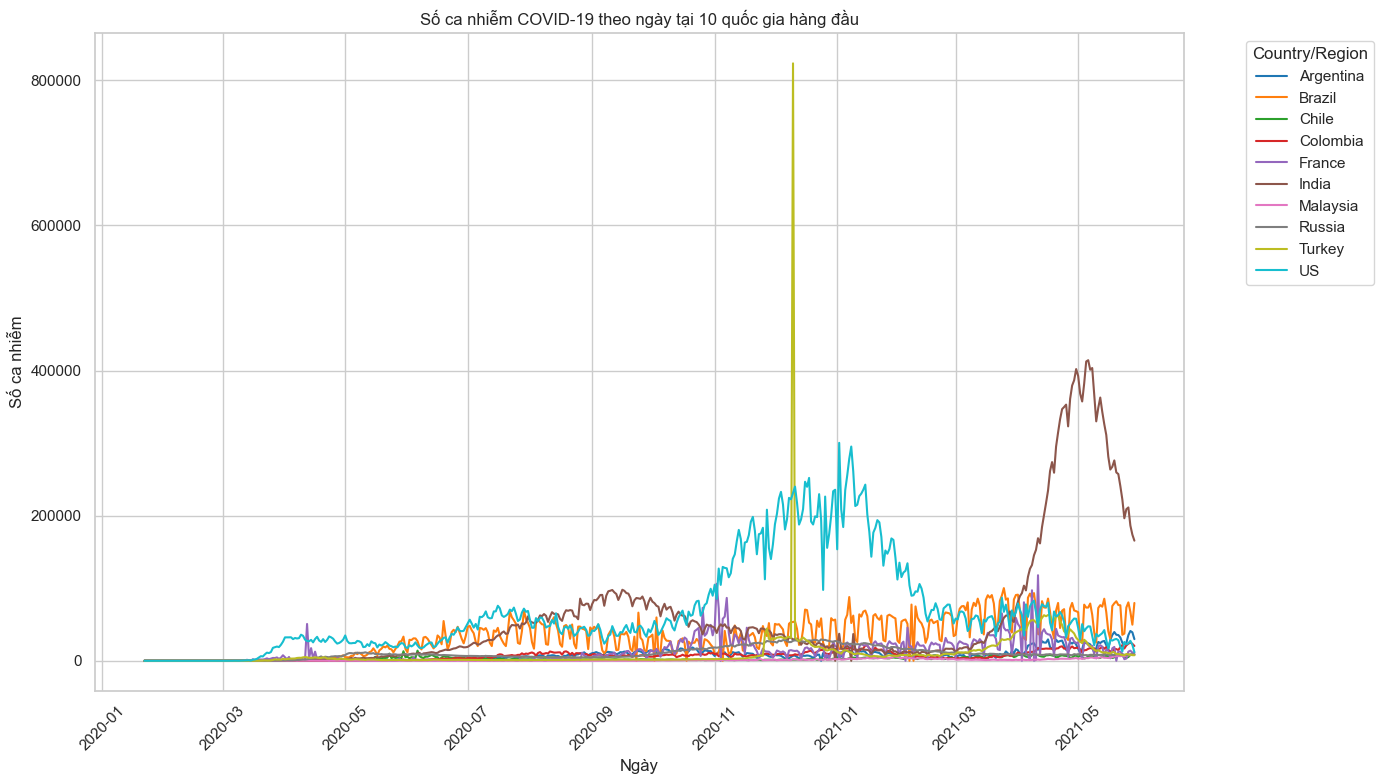

In [110]:
# Chuẩn bị dữ liệu country_wise mới nhất
latest_date = covid_data['ObservationDate'].max()
df_country_wise_latest = covid_data[covid_data['ObservationDate'] == latest_date]
df_country_wise_latest = df_country_wise_latest.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Lấy top 10 quốc gia
top_10_countries_list = df_country_wise_latest.nlargest(10, 'Confirmed')['Country/Region'].tolist()

# Lọc dữ liệu theo các quốc gia này
df_top10 = covid_data[covid_data['Country/Region'].isin(top_10_countries_list)]

# Gom nhóm theo ngày và quốc gia
df_top10_grouped = df_top10.groupby(['ObservationDate', 'Country/Region'])[['Confirmed']].sum().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(14,8))
sns.lineplot(x='ObservationDate', y='Confirmed', hue='Country/Region', data=df_top10_grouped, palette='tab10')
plt.title('Số ca nhiễm COVID-19 theo ngày tại 10 quốc gia hàng đầu')
plt.xlabel('Ngày')
plt.ylabel('Số ca nhiễm')
plt.legend(title='Country/Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Phân tích top 10 quốc gia có tỷ lệ tử vong trên số ca nhiễm cao nhất

#### Số ca nhiễm và tử vong ở Top 10 quốc gia có **CFR cao nhất**

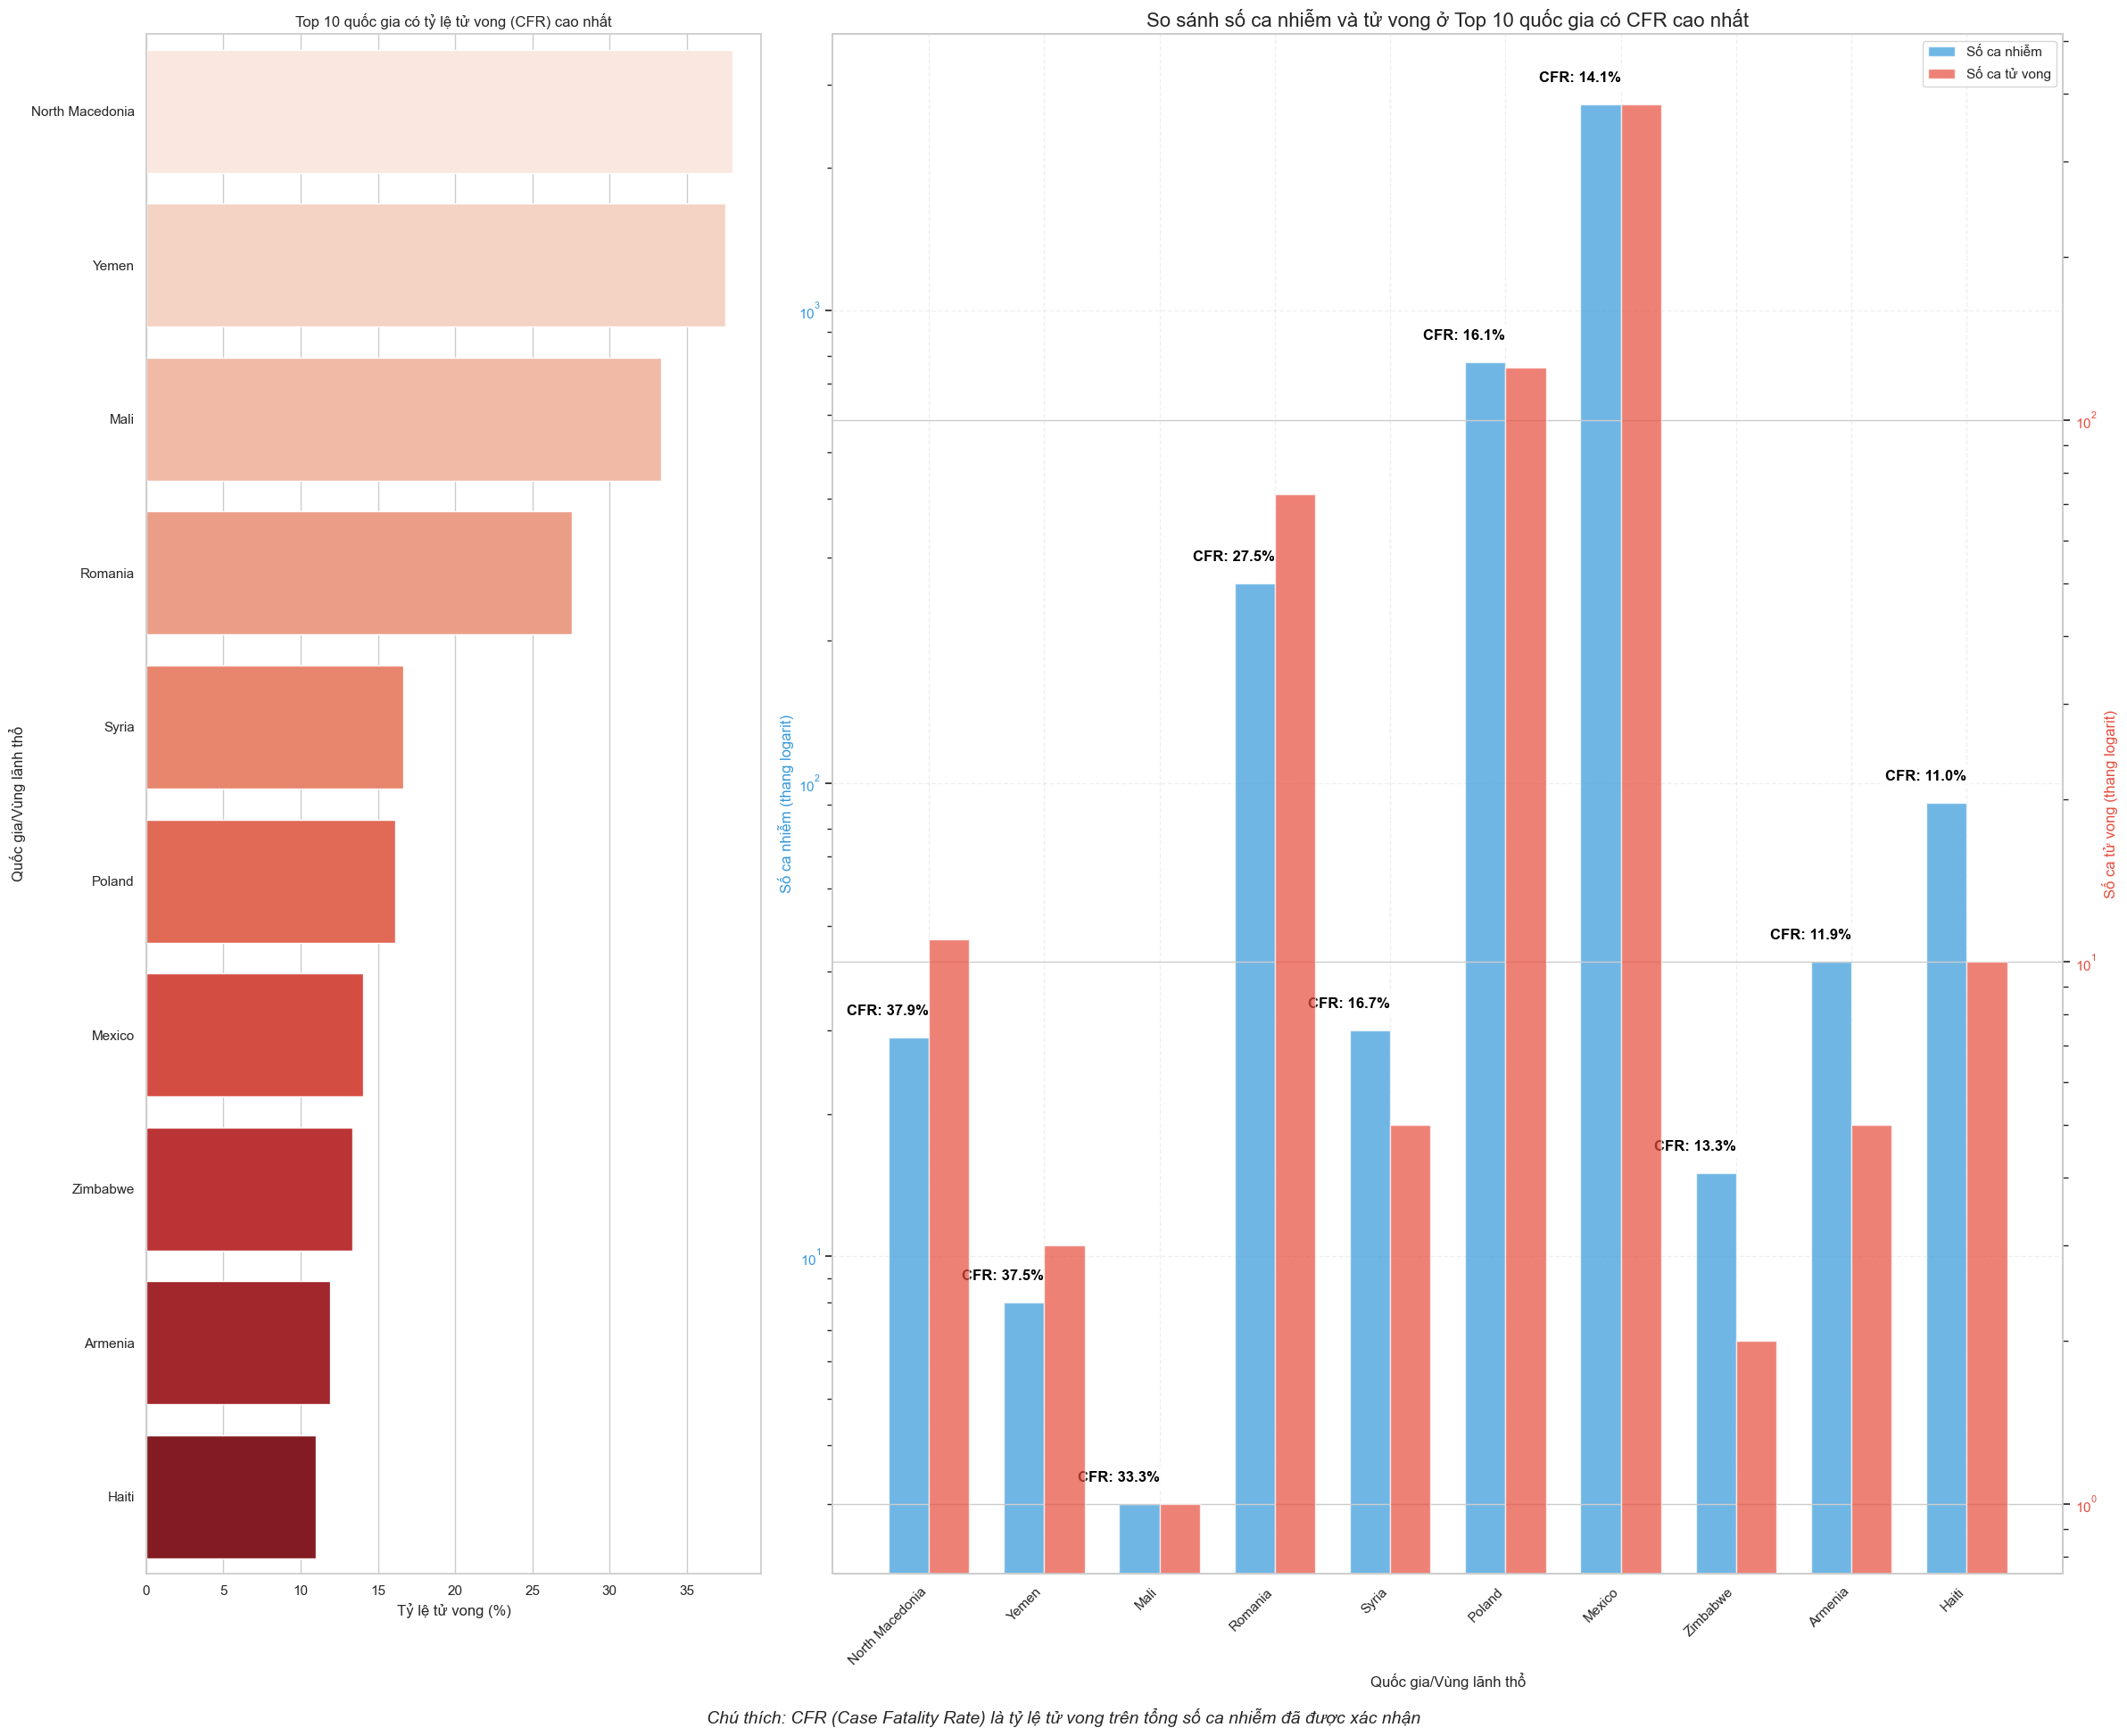

In [111]:
# Tính tỷ lệ tử vong (CFR)
df_country_wise_latest['CFR (%)'] = (df_country_wise_latest['Deaths'] / df_country_wise_latest['Confirmed']) * 100
df_country_wise_latest = df_country_wise_latest.replace([np.inf, -np.inf], np.nan).dropna(subset=['CFR (%)'])

# Top 10 quốc gia có tỷ lệ tử vong cao nhất
top_10_cfr = df_country_wise_latest.nlargest(10, 'CFR (%)')

# Tạo figure chứa cả hai biểu đồ với tỷ lệ chiều rộng khác nhau (1:2)
fig, axes = plt.subplots(1, 2, figsize=(24, 20), 
                        gridspec_kw={'width_ratios': [1, 2]})  # Biểu đồ 1 chiếm 1/3 tổng chiều rộng

# Top 10 quốc gia có tỷ lệ tử vong cao nhất
sns.barplot(
    x='CFR (%)',
    y='Country/Region',
    data=top_10_cfr,
    palette='Reds',
    hue='Country/Region',
    legend=False,
    ax=axes[0]
)

axes[0].set_title('Top 10 quốc gia có tỷ lệ tử vong (CFR) cao nhất')
axes[0].set_xlabel('Tỷ lệ tử vong (%)')
axes[0].set_ylabel('Quốc gia/Vùng lãnh thổ')


# ---------------------------------------------------------------------------
# So sánh số ca nhiễm và tử vong

countries = top_10_cfr['Country/Region']
confirmed_cases = top_10_cfr['Confirmed']
deaths = top_10_cfr['Deaths']

x = np.arange(len(countries))
width = 0.35  # Độ rộng của cột

rects1 = axes[1].bar(x - width/2, confirmed_cases, width, label='Số ca nhiễm', color='#3498db', alpha=0.7)
axes[1].set_yscale('log')
axes[1].set_ylabel('Số ca nhiễm (thang logarit)', color='#3498db')
axes[1].tick_params(axis='y', labelcolor='#3498db')

ax2 = axes[1].twinx()
rects2 = ax2.bar(x + width/2, deaths, width, label='Số ca tử vong', color='#e74c3c', alpha=0.7)
ax2.set_yscale('log')
ax2.set_ylabel('Số ca tử vong (thang logarit)', color='#e74c3c')
ax2.tick_params(axis='y', labelcolor='#e74c3c')

for i, cfr in enumerate(top_10_cfr['CFR (%)']):
    axes[1].text(i, confirmed_cases.iloc[i]*1.1, f'CFR: {cfr:.1f}%',
          ha='right', va='bottom', fontweight='bold', color='black',
          bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

axes[1].set_title('So sánh số ca nhiễm và tử vong ở Top 10 quốc gia có CFR cao nhất', fontsize=16)
axes[1].set_xticks(x)
axes[1].set_xticklabels(countries, rotation=45, ha='right')
axes[1].set_xlabel('Quốc gia/Vùng lãnh thổ')
axes[1].grid(True, alpha=0.3, linestyle='--')


handles1, labels1 = axes[1].get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
axes[1].legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.figtext(0.5, 0.01,
        "Chú thích: CFR (Case Fatality Rate) là tỷ lệ tử vong trên tổng số ca nhiễm đã được xác nhận",
        ha="center", fontsize=14, style='italic')

plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.show()

#### Số ca nhiễm và tử vong ở Top 10 quốc gia có **số ca nhiễm cao nhất**

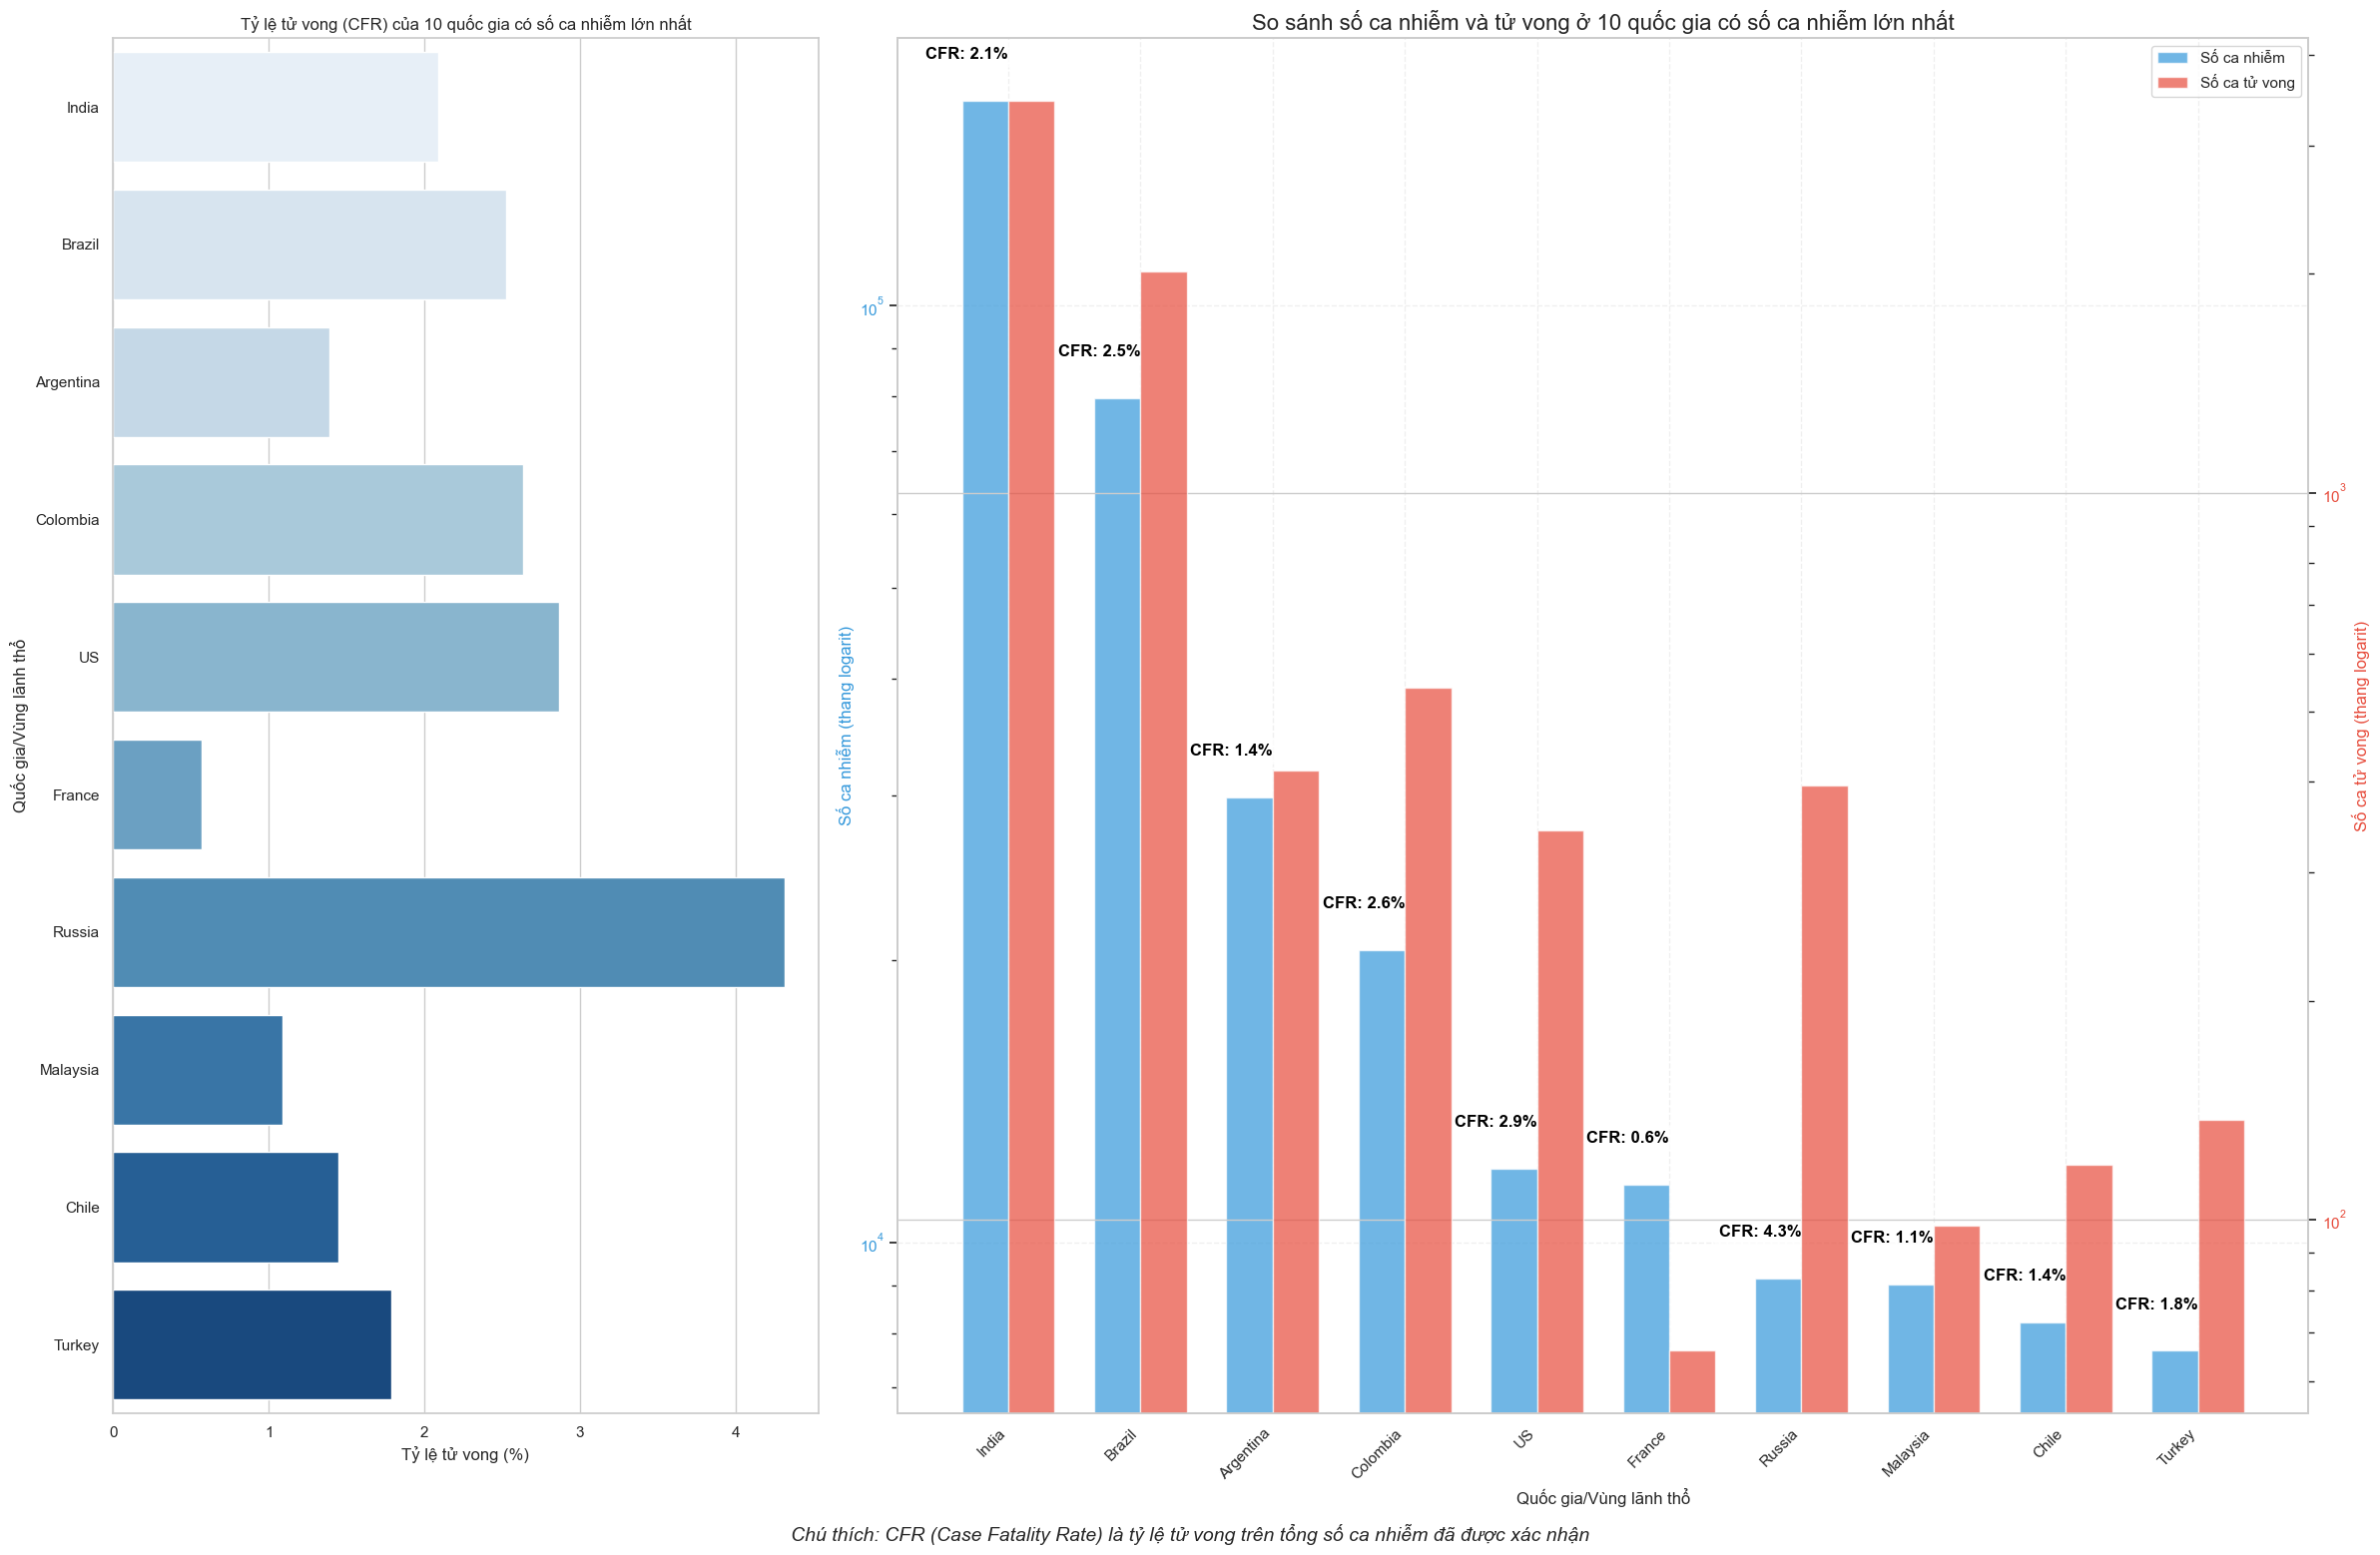

In [112]:
# Chuẩn bị dữ liệu country_wise mới nhất
latest_date = covid_data['ObservationDate'].max()
df_country_wise_latest = covid_data[covid_data['ObservationDate'] == latest_date]
df_country_wise_latest = df_country_wise_latest.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Tính tỷ lệ tử vong (CFR)
df_country_wise_latest['CFR (%)'] = (df_country_wise_latest['Deaths'] / df_country_wise_latest['Confirmed']) * 100
df_country_wise_latest = df_country_wise_latest.replace([np.inf, -np.inf], np.nan).dropna(subset=['CFR (%)'])

# Lấy top 10 quốc gia có số ca nhiễm lớn nhất
top_10_countries = df_country_wise_latest.nlargest(10, 'Confirmed')

# Tạo figure chứa cả hai biểu đồ với tỷ lệ chiều rộng khác nhau (1:2)
fig, axes = plt.subplots(1, 2, figsize=(24, 16), 
                        gridspec_kw={'width_ratios': [1, 2]})  # Biểu đồ 1 chiếm 1/3 tổng chiều rộng

# Top 10 quốc gia có số ca nhiễm lớn nhất và tỷ lệ tử vong (CFR)
sns.barplot(
    x='CFR (%)',
    y='Country/Region',
    data=top_10_countries,
    palette='Blues',
    hue='Country/Region',
    legend=False,
    ax=axes[0]
)

axes[0].set_title('Tỷ lệ tử vong (CFR) của 10 quốc gia có số ca nhiễm lớn nhất')
axes[0].set_xlabel('Tỷ lệ tử vong (%)')
axes[0].set_ylabel('Quốc gia/Vùng lãnh thổ')

# So sánh số ca nhiễm và tử vong
countries = top_10_countries['Country/Region']
confirmed_cases = top_10_countries['Confirmed']
deaths = top_10_countries['Deaths']

x = np.arange(len(countries))
width = 0.35  # Độ rộng của cột

rects1 = axes[1].bar(x - width/2, confirmed_cases, width, label='Số ca nhiễm', color='#3498db', alpha=0.7)
axes[1].set_yscale('log')
axes[1].set_ylabel('Số ca nhiễm (thang logarit)', color='#3498db')
axes[1].tick_params(axis='y', labelcolor='#3498db')

ax2 = axes[1].twinx()
rects2 = ax2.bar(x + width/2, deaths, width, label='Số ca tử vong', color='#e74c3c', alpha=0.7)
ax2.set_yscale('log')
ax2.set_ylabel('Số ca tử vong (thang logarit)', color='#e74c3c')
ax2.tick_params(axis='y', labelcolor='#e74c3c')

for i, cfr in enumerate(top_10_countries['CFR (%)']):
    axes[1].text(i, confirmed_cases.iloc[i]*1.1, f'CFR: {cfr:.1f}%',
          ha='right', va='bottom', fontweight='bold', color='black',
          bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

axes[1].set_title('So sánh số ca nhiễm và tử vong ở 10 quốc gia có số ca nhiễm lớn nhất', fontsize=16)
axes[1].set_xticks(x)
axes[1].set_xticklabels(countries, rotation=45, ha='right')
axes[1].set_xlabel('Quốc gia/Vùng lãnh thổ')
axes[1].grid(True, alpha=0.3, linestyle='--')

handles1, labels1 = axes[1].get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
axes[1].legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.figtext(0.5, 0.01,
        "Chú thích: CFR (Case Fatality Rate) là tỷ lệ tử vong trên tổng số ca nhiễm đã được xác nhận",
        ha="center", fontsize=14, style='italic')

plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.show()

**Nhận xét:**

- Có thể thấy, các quốc gia như Yemen, Mali, Syria, Zimbabwe có tỷ lệ tử vong trong COVID-19 cao dù số ca nhiễm thấp so với các nước khác trên thế giới, thấp hơn đáng kể khi so với top 10 nước có số ca nhiễm cao nhất. Ví dụ, đối với ***top 10 quốc gia có số ca nhiễm cao nhất***, đa số đều có số ca nhiễm lớn hơn $10^3$ (thang log) nhưng CFR đều thâps hơn $5$% trong khi ***top 10 quốc gia có CFR cao nhất*** lại có số ca nhiễm thấp dưới $10^4$ (thang log) nhưng CFR đều cao hơn $11$%   
- Nguyên nhân có thể suy đoán ra từ thông tin này có thể là do đa số các nước trên  là các nước kém phát triển, thiếu cơ sở hạ tầng, giường bệnh và nhân viên y tế, tỷ lệ xét nghiệm và tiêm vaccine thấp hoặc vaccine khan hiếm. 

**Lưu ý:**
Dữ liệu thu thập được có thể không đầy đủ. Số ca nhiễm thực tế có thể cao hơn báo cáo vì ***có một số cột số ca nhiễm thấp hơn số ca tử vong.***

## Xử lý dữ liệu theo châu lục

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import country_converter as coco
import numpy as np
from scipy.stats import pearsonr
# Bước 1: Lấy ngày mới nhất trong dữ liệu
latest_date = covid_data['ObservationDate'].max()

# Bước 2: Lọc dữ liệu ngày mới nhất
df_latest = covid_data[covid_data['ObservationDate'] == latest_date].copy()

# Bước 3: Gom nhóm theo quốc gia
df_latest_grouped = df_latest.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

cc = coco.CountryConverter()

df_latest_grouped['Continent'] = cc.convert(names=df_latest_grouped['Country/Region'], to='continent')
# Bỏ các hàng không xác định được châu lục
df_latest_grouped = df_latest_grouped[df_latest_grouped['Continent'] != 'not found']
df_latest_grouped = df_latest_grouped[df_latest_grouped['Continent'] != 'Oceania']

Diamond Princess not found in regex
MS Zaandam not found in regex


Hai con tàu Diamond Pricess và MS Zaadam là trường hợp đặc biệt khi thời gian khảo sát là khoảng thời gian 2 con tàu du lịch ra khơi nên sẽ không được tính vào phần châu lục và phần Châu Đại Dương do có quá ít ảnh hưởng nên cũng sẽ không được thêm vào

Tổng số ca, tử vong, hồi phục theo châu lục (Continent)

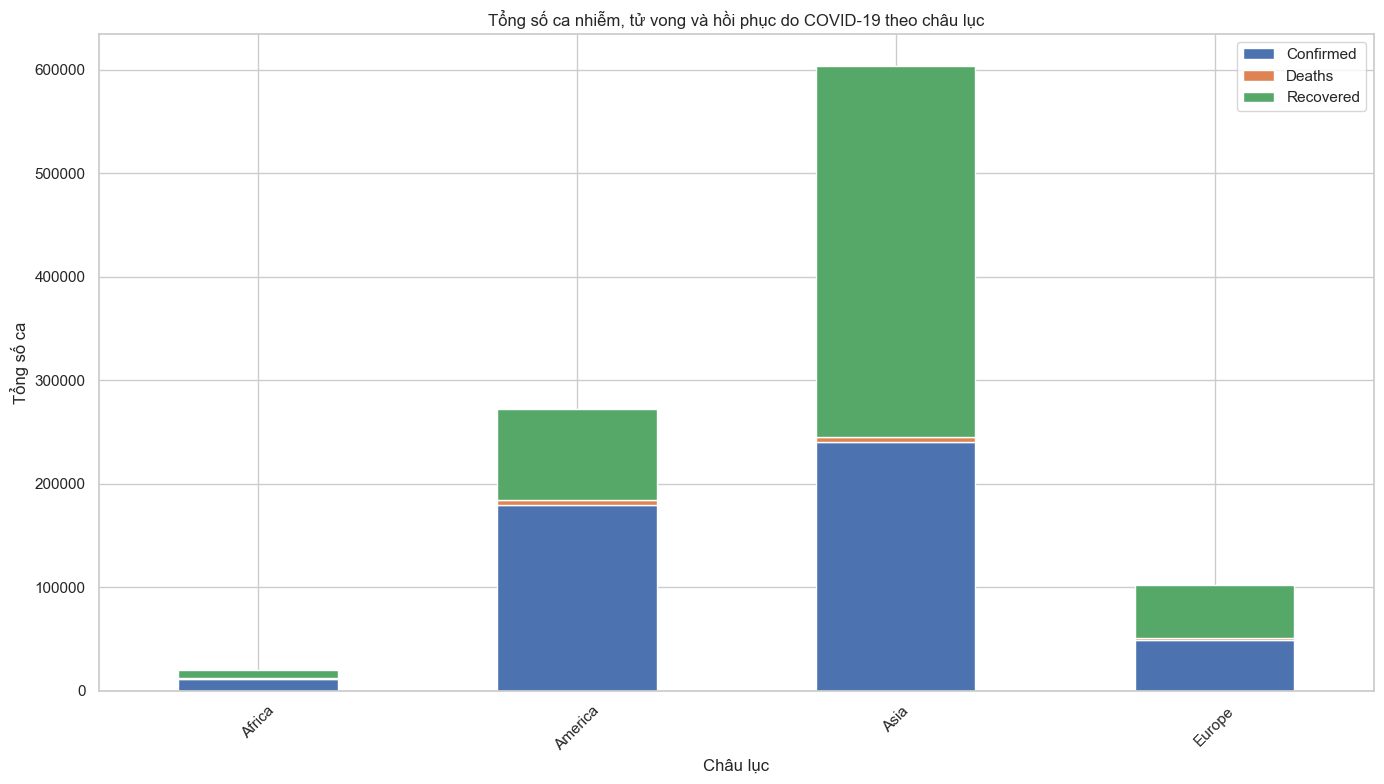

In [114]:
continent_data = df_latest_grouped.groupby('Continent')[['Confirmed', 'Deaths', 'Recovered']].sum()

# Vẽ stacked bar chart
continent_data.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Tổng số ca nhiễm, tử vong và hồi phục do COVID-19 theo châu lục')
plt.xlabel('Châu lục')
plt.ylabel('Tổng số ca')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Tỷ lệ tử vong và hồi phục theo châu lục

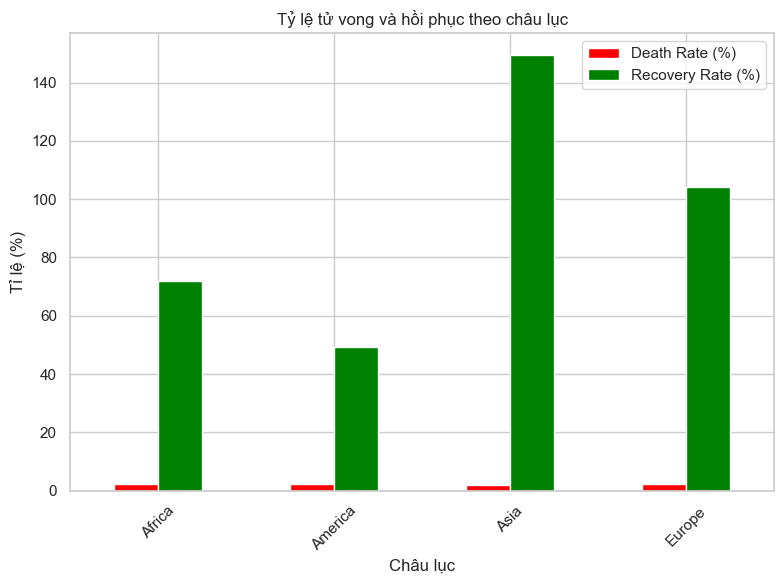

In [115]:
continent_data['Death Rate (%)'] = (continent_data['Deaths'] / continent_data['Confirmed']) * 100
continent_data['Recovery Rate (%)'] = (continent_data['Recovered'] / continent_data['Confirmed']) * 100

continent_data[['Death Rate (%)', 'Recovery Rate (%)']].plot(
    kind='bar', figsize=(8, 6), color=['red', 'green']
)

plt.title('Tỷ lệ tử vong và hồi phục theo châu lục')
plt.xlabel('Châu lục')
plt.ylabel('Tỉ lệ (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Phân phối tổng số ca bệnh theo châu lục

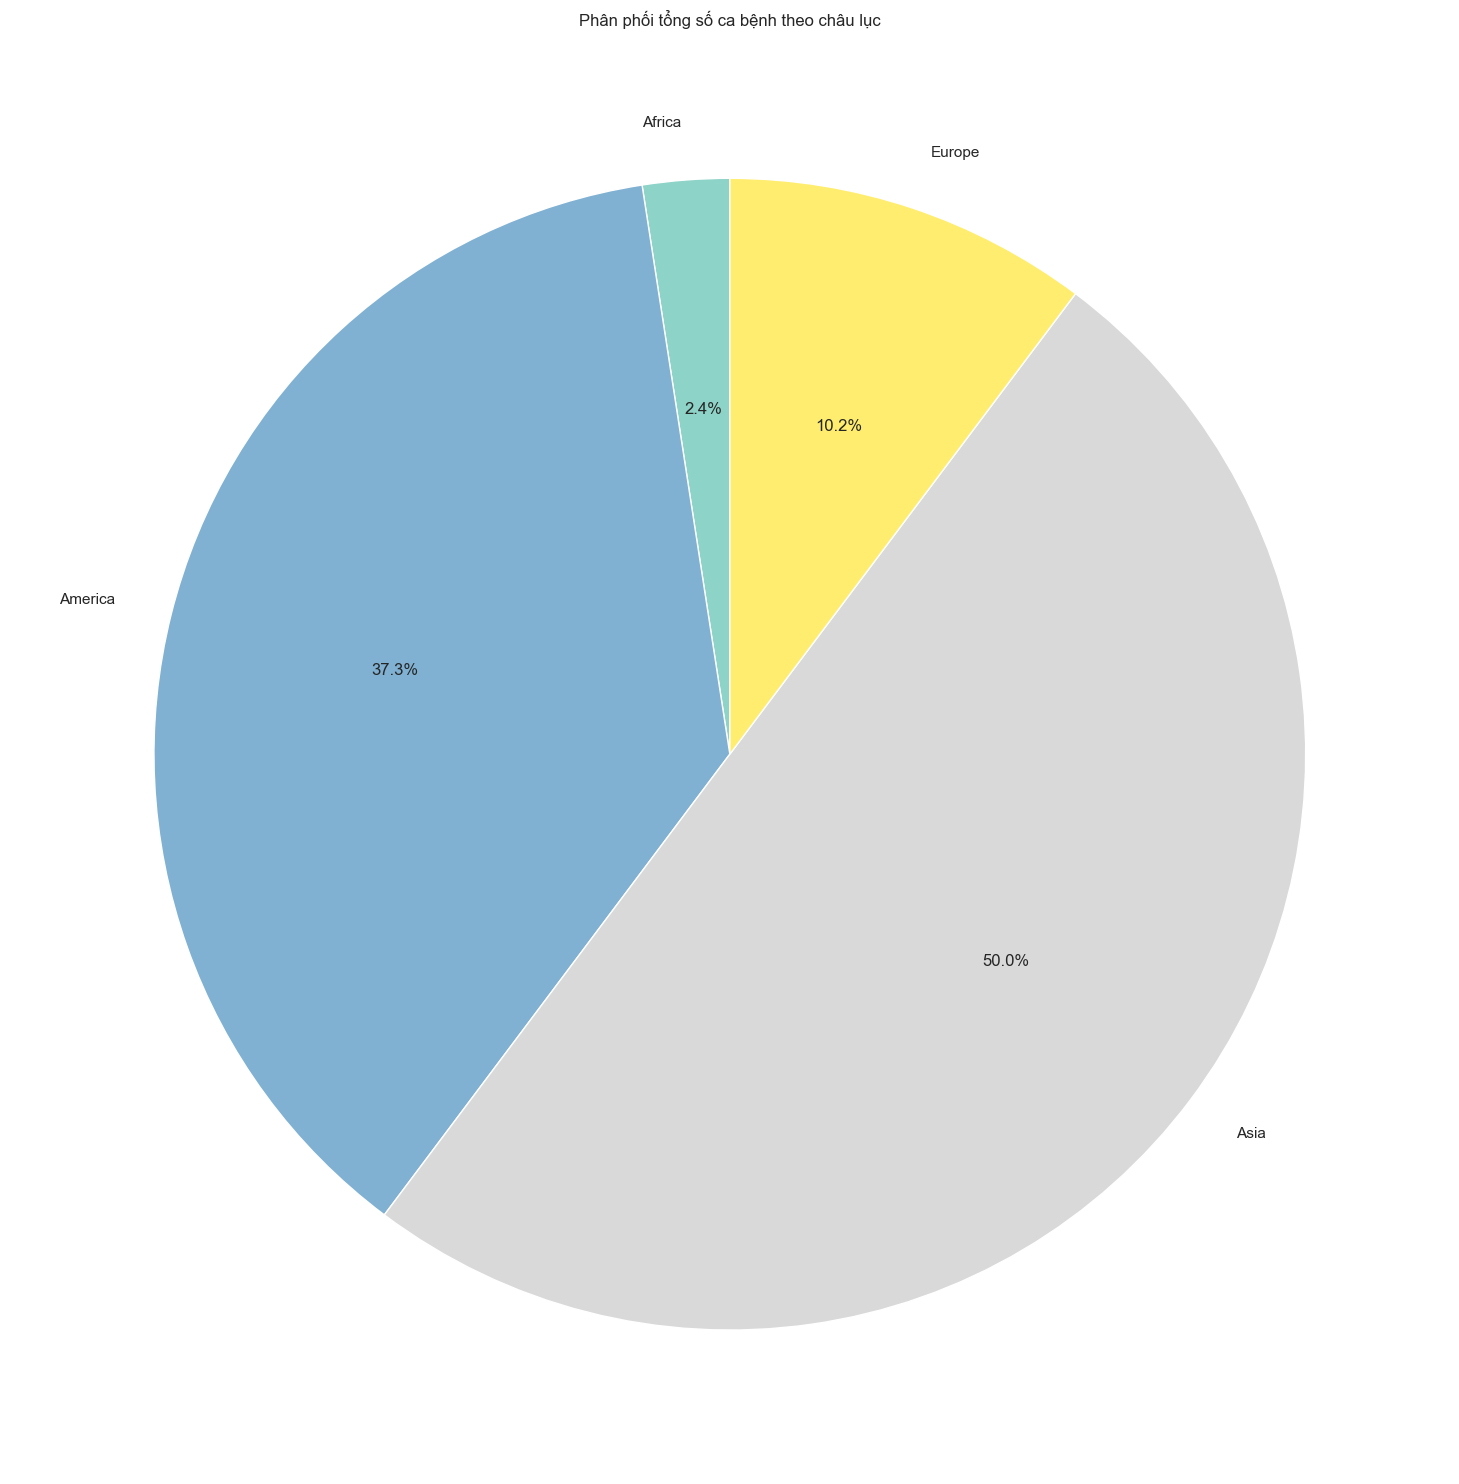

In [116]:
continent_cases = df_latest_grouped.groupby('Continent')['Confirmed'].sum()
plt.figure(figsize=(15, 15))
continent_cases.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.title('Phân phối tổng số ca bệnh theo châu lục')
plt.ylabel('')
plt.tight_layout()
plt.show()


## Bản đồ phân bố số ca nhiễm COVID-19 trên toàn cầu

In [117]:
import plotly.express as px


# Chuẩn bị dữ liệu: df_latest_grouped đã có cột 'Country/Region' và 'Confirmed'
# Nếu chưa có thì dùng đoạn xử lý ở trên để tạo

fig = px.scatter_geo(
    df_latest_grouped,
    locations="Country/Region",
    locationmode="country names",
    size="Confirmed",
    color_discrete_sequence=["red"],
    hover_name="Country/Region",
    hover_data={"Confirmed": True},
    projection="natural earth",
    title="Global COVID-19 Infections by Country (Bubble Map)",
    size_max=50  # bạn có thể chỉnh max size của chấm
)

fig.update_layout(
    geo=dict(showland=True, landcolor="lightgray"),
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()
